In [1]:
%pwd

'/notebooks/workdir/gad_former'

In [2]:
#%pip install -r ./requirements.txt

In [3]:
import utils
import importlib
from utils import seed_worker

import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [4]:
dataset_fpath='./datasets/files_valid/Trajectorys2_72_2000_anom.csv'
#dataset_fpath='./datasets/files_valid/brightkite_500_1569_2.1_train_unsup.csv'
class_label = {'abnormal': 1, 'normal': 0}
col_grpID='Entity'
col_label='Label'
cols_seq=['Step']
cols_feat=['X_Coord', 'Y_Coord']
cols_X = cols_seq+[col_grpID]+cols_feat
cols_y = cols_seq+[col_grpID]+[col_label]

scaler = 'standard'  # 'robust', 'standard', None

df = pd.read_csv(dataset_fpath)
X = df[cols_X].set_index(cols_seq)
y = df[cols_y].set_index(cols_seq)

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler

X.reset_index(inplace=True)
X.set_index(cols_seq+[col_grpID], inplace=True)

if scaler == 'standard':
    X_sc = StandardScaler().fit_transform(X)
elif scaler == 'robust':
    X_sc = RobustScaler().fit_transform(X)
else:
    X_sc = X.to_numpy()
    
X_sc = pd.DataFrame(X_sc, index=X.index, columns=cols_feat).reset_index()
X_sc

,Step,Entity,X_Coord,Y_Coord
0,0,1,-1.664489,-1.186020
1,0,2,-1.616438,-0.988669
2,0,3,-1.616438,-1.270599
3,0,4,-1.664489,-1.073248
4,0,5,-1.664489,-1.129634
...,...,...,...,...
143995,71,1996,1.867256,0.900267
143996,71,1997,2.059460,0.082668
143997,71,1998,1.795180,0.195440
143998,71,1999,1.843231,1.294970


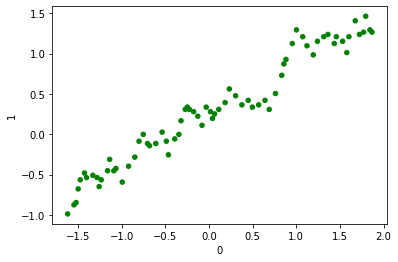

In [6]:
X_new=[]
y_new=[]
for grpid in X_sc[col_grpID].unique():
    X_new.append(X_sc.query(f"{col_grpID} == {grpid}")[cols_feat])
    y_new.append(y.query(f"{col_grpID} == {grpid}")[col_label][0])
X_new=np.array(X_new)
y_new=np.array(y_new)

plot_grpidx_normal   = y.query(f"{col_label} == {class_label['normal']}")[col_grpID].iloc[0]
plot_grpidx_abnormal = y.query(f"{col_label} == {class_label['abnormal']}")[col_grpID].iloc[0]

plot_idx=plot_grpidx_normal # plot_grpidx_abnormal , plot_grpidx_normal

plot_grp = y.query(f"{col_grpID} == {plot_idx}")
plot_clr = ['g' if y_ == 0 else 'r' for y_ in plot_grp[col_label]]
pd.DataFrame(X_new[plot_idx]).plot.scatter(x=0,y=1,c=plot_clr)

X = torch.tensor(X_new)
y = torch.tensor(y_new)

# trajectories, sequence-step, entity_features
# X_new.shape # (256, 72, 2)
# y_new.shape # (256,)

<AxesSubplot: xlabel='X_Coord'>

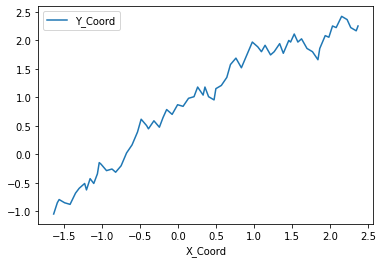

In [7]:
# './datasets/brightkite_500.csv'
#grpid = 26250  # grpID abnormal: 241, 636, 1118, 1138, 1285, 26066, 26250, 29691, 41378, 48737
grpid = 117
pd.DataFrame(X_sc.query(f"{col_grpID} == {grpid}")[cols_feat]).plot(x=0,y=1)

In [8]:
def scaled_dot_product(q, k, v, mask=None): # source: https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

x=X

m = 256 # x.shape[0] # samples (batch size)
n = x.shape[1] # seq_len (trajectory steps - concatenated sample features)
f = x.shape[2] # entity step features
# torch.Size([256, 72, 2])

num_heads = 8

d_inp_size = x.shape[1] #500 #72 # n
d_step_feat = f # f
d_inp_embed_size = 1 # 1
h = 8 # num heads
d_k = x.shape[1] # 8 # d_q = d_k = d_v # 72 - todo: 8, 16, 32, 512, 2048
d_ffn_embed_size = 2048 # (Vaswani et al.)
d_qkv = 3*d_k # 216 # 1536

inp_emb = nn.Linear(f, d_inp_embed_size)
inp_prj = nn.Linear(d_inp_size, d_k)
qkv_prj = nn.Linear(d_k, h * d_qkv) # MHA
out_prj = nn.Linear(h, d_inp_embed_size)

In [9]:
x = X[:m, :]
x = x.float()
#q,k,v = x,x,x
print(x.dtype)
x.shape

torch.float32


torch.Size([256, 72, 2])

In [10]:
def freeze_weights(model, param_name, unfreeze, verbose=False):
    for a, b in model.named_parameters():
        if param_name in a:
            b.requires_grad=unfreeze
            if verbose: print(b)

class InputEmbedding(nn.Module):
    
    def __init__(self, d_inp_size, d_step_feat, d_inp_embed_size, static_encoding=False):
        super(InputEmbedding, self).__init__()
        
        self.d_k = d_inp_size # d_k # 72 # trajectory steps
        self.d_step_feat = d_step_feat # 2
        self.d_inp_embed_size = d_inp_embed_size # 8
        
        # from input_net (input_dim -- prj -> model_dim)
        # source: https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html (image) vs gadf (trajectory)
        # student: input adaption to trajectories
        
        self.inp_prj_feat = nn.Linear(d_step_feat, d_inp_embed_size)
        
        # for future transformer layer capability investigation
        #if static_encoding:
        #    freeze_weights(self, 'inp_prj_feat', unfreeze=False)
        #    #freeze_weights(self, 'inp_prj_grp', unfreeze=False)
        #else:
        #    freeze_weights(self, 'inp_prj_feat', unfreeze=True)
        #    #freeze_weights(self, 'inp_prj_grp', unfreeze=True)
        
    def forward(self, x):
        
        # x - torch.Size([256, 72, 2])
        # m = x.shape[0] #bs
        
        x1 = self.inp_prj_feat(x) # torch.Size([256, 72, 8])      
        
        return x1  

In [11]:
d_inp_size = x.shape[1] #500 #72 # d_k = 72 # d_model
d_inp_embed_size = 16
d_step_feat = 2
d_k = d_inp_size

x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([256, 72, 2])
inp_emb = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size)
x1 = inp_emb.forward(x0)
x1.shape # torch.Size([256, 72, 8]) - v1: torch.Size([256, 72, 1]) v2: torch.Size([256, 72, 8])

/tmp/ipykernel_729/875668327.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([256, 72, 2])


torch.Size([256, 72, 16])

In [12]:
import time
import gc

In [13]:
class SHAtt(nn.Module):
    
    #def __init__(self, d_k, d_model, d_inp_embed_size, winit_orig=True):
    def __init__(self, d_model, d_k, d_inp_embed_size, winit_orig=True):
        super(SHAtt, self).__init__()
        
        # v2: d_inp_size = d_k = d_model = n
        self.d_model = d_model
        self.d_k = d_k # ( Vaswani et al. -> d_q = d_k = d_v = d_model ) = 32, 512, 2048   
        
        # v2: 8 = projected group member (traj-step) features f (8 originated from LightningTutorialVersion with further hyperparameter search - others 4, 16, 72, 100, etc.) 
        # v1: 1 = embedded group member (traj-step) features f      
        self.d_inp_embed_size = d_inp_embed_size 
        #self.d_qkv = 3*d_model # v3
        self.d_qkv = 3*d_k # v4
        
        if winit_orig is None or winit_orig:
            #self.fc_qkv = nn.Linear(self.d_k, self.d_qkv, bias=True) # SHA v3
            self.fc_qkv = nn.Linear(self.d_model, self.d_qkv, bias=True) # SHA v4
        else:
            #self.fc_qkv = nn.Linear(self.d_k, self.d_qkv, bias=False) # Karpathy et al. (-> d_k != d_model, d_k=d_inp_size, d_model=d_model) # SHA v3
            self.fc_qkv = nn.Linear(self.d_model, self.d_qkv, bias=False) # Karpathy et al. (-> d_k != d_model, d_k=d_inp_size, d_model=d_model) # SHA v4
        
        self._reset_parameters(winit_orig)
        

    def _reset_parameters(self, winit_orig=True):
        if winit_orig is not None:
            # Original Transformer initialization, see PyTorch documentation
            if winit_orig:
                # https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html (LightningTutorialVersion)
                nn.init.xavier_uniform_(self.fc_qkv.weight)
                self.fc_qkv.bias.data.fill_(0)
            else:
                # Karpathy et al.
                nn.init.normal_(self.fc_qkv.weight, mean=0., std=np.sqrt(2/(self.d_k+self.d_model)))

    def scaled_dot_product(self, q, k, v, mask=None):
        # source: https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/05-transformers-and-MH-attention.html (LightningTutorialVersion)
        d_k = q.size()[-1]
        attn_logits = torch.matmul(q, k.transpose(-2, -1))
        attn_logits = attn_logits / math.sqrt(d_k)
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
        attention = F.softmax(attn_logits, dim=-1)
        values = torch.matmul(attention, v)
        return values, attention
        
    def forward(self, x):
        
        # x - torch.Size([256,  72, 8])
        # x - torch.Size([256, d_k, 8])
        
        m = x.shape[0] # number of groups in batch = bs
        
        x1 = x.permute((0, 2, 1))                             # v2: torch.Size([256, 8, 72])  v1: torch.Size([256, 1, 72])
        x2 = self.fc_qkv(x1)                                  # v2: torch.Size([256, 8, 216]) v1: torch.Size([256, 1, 216]) - d_model = d_inp_size = 72 (fc_qkv: 3*d_k)
        x3 = x2.permute((0, 2, 1))                            # v2: torch.Size([256, 216, 8])
        
        # v4: d_model = d_inp_size
        # v4: d_k != d_model (Karpathy)
        # Vaswani: d_k = d_model/h
        
        q = x3[:, :self.d_k, :].clone()
        k = x3[:, self.d_k:2*self.d_k, :].clone()
        v = x3[:, 2*self.d_k:, :].clone()
        
        #q = x3[:, :self.d_model, :].clone()
        #k = x3[:, self.d_model:2*self.d_model, :].clone()
        #v = x3[:, 2*self.d_model:, :].clone()
        
        #q = x2[:, :, :self.d_model].reshape(m, self.d_model, self.d_inp_embed_size)               # v2: torch.Size([256, d_model, 8]) - d_model=d_q , v1: torch.Size([256, 72, 1])
        #k = x2[:, :, self.d_model:2*self.d_model].reshape(m, self.d_model, self.d_inp_embed_size) # v2: torch.Size([256, d_model, 8]) - d_model=d_k , v1: torch.Size([256, 72, 1])
        #v = x2[:, :, 2*self.d_model:].reshape(m, self.d_model, self.d_inp_embed_size)             # v2: torch.Size([256, d_model, 8]) - d_model=d_v , v1: torch.Size([256, 72, 1])
        
        out, att = self.scaled_dot_product(q, k, v, mask=None) # v4: torch.Size([256, d_k, 8]) v2: torch.Size([256, d_model, 8]) v1: torch.Size([256, 72, 1]) , att - torch.Size([256, d_model, d_model])
        
        return out, att
  
    
d_inp_size = x.shape[1] # 72 # d_k = 72 # d_model
d_inp_embed_size = 16


shatt1 = SHAtt(d_model=d_inp_size, d_k=d_inp_size, d_inp_embed_size=d_inp_embed_size)
shatt2 = SHAtt(d_model=d_inp_size, d_k=d_inp_size, d_inp_embed_size=d_inp_embed_size)
out1, attn1 = shatt1(x1)
out2, attn2 = shatt2(x1)
print(f"out: {out1.shape} - attn: {attn1.shape}")  # out: torch.Size([256, 72, 8]) - attn: torch.Size([256, 72, 72])
                                     # out: torch.Size([m, d_k, d_imp_embed_size]) - attn: torch.Size([m, d_k, d_k])
           # out O_mb after concat and prj: torch.Size([m, d_model, d_imp_embed_size])

out: torch.Size([256, 72, 16]) - attn: torch.Size([256, 72, 72])


In [14]:
#bs, seq_len, emb_dim = 2, 3, 5
#a1 = torch.randn((bs, seq_len, emb_dim)) 
#a1r = a1.reshape((bs, emb_dim, seq_len)) # with constant bs dimension reshape reshapes only the internal sample representation and returns a copy of the tensor 
# - unclear, if returned result is of same storage (ref) or copy - but can handle contiguous AND non-contiguous input

#a1v = a1.view(bs, emb_dim, seq_len) # returns a new tensor copy of the self tensor with copied contents but different given (new) view (shape) 
# -> if original tensor changes also viewed tensor changes and vice versa

#a1p = a1.permute((0, 2, 1)) # returns just a view of the original self tensor with permuted dimensions
#a1p # 2, 5, 3

#a1p = a1.permute((0, 2, 1)).view((bs,emb_dim,seq_len)) # returns just a view of the original self tensor with permuted dimensions
#a1p # 2, 5, 3

#a2 = a1.permute((0, 2, 1))                             # v2: torch.Size([256, 8, 72])  v1: torch.Size([256, 1, 72])
#a2 # torch.Size([2, 5, 3])

In [15]:
shatt1 = None
shatt2 = None
inp_emb= None
attn1 = None
attn2 = None
out1 = None
out2 = None
gc.collect()

3498

In [16]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, d_inp_embed_size):
        super(PositionalEncoding, self).__init__()
        
        # d_model = d_inp_size
        
        self.pe = torch.zeros(d_inp_embed_size, d_model) # 8, 72        
        self.pe.requires_grad = False
        
        for pos in range(0, d_inp_embed_size): 
            for i in range(0, d_model):
                
                if 2*i < d_model: denom = 10000. ** (2*i/d_model)    
                if 2*i < d_model: self.pe[pos,2*i] = math.sin( pos / denom )
                if 2*i+1 < d_model: self.pe[pos,2*i+1] = math.cos( pos / denom )
        
        self.pe = self.pe.permute((1, 0)) # 72, 8
                    
        #self.register_buffer("pe", pe, persistent=False)
        
    def to(self, device):
        self.pe = self.pe.to(torch.device(device))
        return self
        
    def forward(self, x, **kwargs):
        return self.pe[:, :x.size(1)].to(x.device.type) # 72, 8
    

d_inp_size = x.shape[1] # 500 #72 # d_k = 72 # d_model
d_inp_embed_size = 16
d_step_feat = 2
d_k = d_inp_size

x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([256, 72, 2])
inp_emb = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size)
x1 = inp_emb.forward(x0)
x1.shape # torch.Size([256, 72, 8])

p = PositionalEncoding(d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size)
pos_enc = p.forward(x1)
pos_enc.shape # torch.Size([72, 8])

x2 = x1 + pos_enc
x2.shape

/tmp/ipykernel_729/3625893270.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([256, 72, 2])


torch.Size([256, 72, 16])

In [17]:
anomalies = list(np.where(y==1)[0]) # len 188
np.array(anomalies)

array([   7,   55,   57,   60,   73,   76,   80,   83,   94,   99,  105,
        115,  117,  123,  130,  131,  165,  178,  179,  184,  201,  207,
        210,  211,  219,  224,  226,  231,  241,  242,  245,  247,  250,
        294,  297,  300,  311,  317,  347,  354,  384,  405,  443,  500,
        506,  509,  510,  513,  542,  543,  544,  546,  567,  573,  575,
        580,  590,  603,  626,  665,  698,  714,  717,  719,  732,  742,
        748,  783,  809,  826,  839,  842,  860,  867,  885,  901,  906,
        909,  912,  915,  925,  931,  933,  939,  946,  979,  981,  986,
        999, 1016, 1018, 1031, 1032, 1046, 1049, 1096, 1115, 1131, 1132,
       1143, 1158, 1177, 1195, 1231, 1235, 1238, 1292, 1294, 1300, 1330,
       1346, 1350, 1353, 1362, 1367, 1375, 1381, 1386, 1402, 1408, 1411,
       1415, 1424, 1436, 1441, 1449, 1454, 1460, 1461, 1464, 1475, 1501,
       1509, 1527, 1529, 1535, 1555, 1567, 1572, 1581, 1593, 1620, 1631,
       1634, 1637, 1640, 1646, 1652, 1653, 1660, 16

/opt/conda/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/opt/conda/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


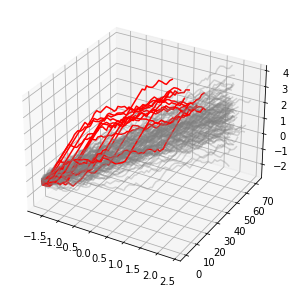

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt

sid=130
fs=5
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(fs,fs))

xa=x0[:sid, :, 0]
ya=x0[:sid, :, 1]

zlst=[]
for _ in range(sid):
    zlst.append(range(d_inp_size))
za=np.array(zlst)

for idx in range(0,sid):
    ax.plot(xa[idx,:], za[idx,:], ya[idx,:], c=('gray','r')[idx in anomalies], alpha=(0.3,1.)[idx in anomalies], label='trajectories')
#ax.legend()

plt.show()

<AxesSubplot: xlabel='0', ylabel='1'>

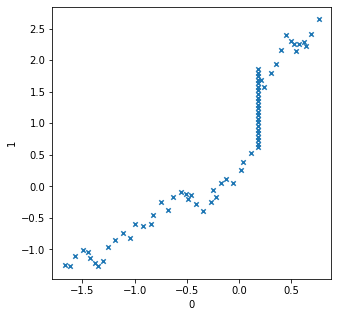

In [19]:
x1.shape #v1: 256, 72, 1, v2: 256, 72, 8
x2.shape #v1: 256, 72, 1, v2: 256, 72, 8
pd.DataFrame(x0[sid].detach().cpu().numpy()).plot.scatter(x=0,y=1, legend=None,figsize=(fs,fs),marker='x') #, list(range(0,x2.shape[1]))).plot(ylim=[-3,3])

<AxesSubplot: title={'center': 'Input Representation'}>

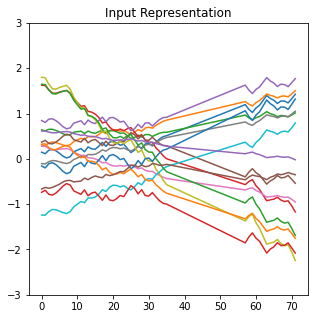

In [20]:
pd.DataFrame(x1[sid].detach().cpu().numpy(), list(range(0,x1.shape[1]))).plot(ylim=[-3,3], legend=None, figsize=(fs,fs), title='Input Representation')

In [21]:
import gc

class BERTInputRepresentation(nn.Module):
    
    def __init__(self, input_token_embedding, positional_encoding, seq_len, seg_len=1, padding_mode='circular', padding_val=None, verbose=False):
        super(BERTInputRepresentation, self).__init__()
        
        self.input_token_embedding = input_token_embedding
        self.positional_encoding = positional_encoding
        self.verbose = verbose
        self.seq_len = seq_len
        self.seg_len = seg_len
        self.padding_mode = padding_mode # 'constant', 'reflect', 'replicate' or 'circular'
        self.padding_val = padding_val # default: None
        
        # calculate sequence separation indicies
        self.lst_split_indicies=list(set(set([i if i % self.seg_len == 0 and i>0 else None for i in range(0, self.seq_len)])-set([None])))
        self.lst_split_indicies.sort()
        if self.verbose: print(lst_split_indicies)
            
        self.fc_seg_embedding = nn.Linear(seg_len, 1)
        
        
    def calculate_segment_embedding(self, x):
        
        # --- segment embedding creation
        
        #t0 = time.time()
        
        # split sequences at separation indicies into segments (chunks)
        chunks = torch.tensor_split(x, self.lst_split_indicies, dim=1)       # torch.Size([256, 22, 8]) - foreach        
        
        seg_embeddings = torch.zeros((x.shape[0], x.shape[1], x.shape[2]))   # torch.Size([256, 72, 8])      
        seg_embeddings.requires_grad = False # to check
        #print(f"a {seg_embeddings.device}")
        
        # create embedding for each segment
        for idx, chunk in enumerate(chunks):
            #t1 = time.time()
            
            x3 = chunk                                                       # torch.Size([256, 22, 8])
            
            # calculate pad_len
            remaining_seg_len = chunk.shape[1]
            pad_len = self.seg_len - remaining_seg_len
            pad = (0, pad_len)

            # pad segment if necessary according to pad_len
            if pad_len == 0:
                x4_ = x3
            else:
                x3_ = x3.permute((0, 2, 1))                                          # torch.Size([256, 8, 22])
                x4 = F.pad(x3_, pad, mode=self.padding_mode, value=self.padding_val) # torch.Size([256, 8, 25]) # todo: reproducibility issue?
                x4_ = x4.permute((0, 2, 1))                                          # torch.Size([256, 25, 8])

            if self.verbose:
                pd.DataFrame(x4_[0].detach().cpu().numpy(), list(range(0,x4_.shape[1]))).plot(xlim=[-1,26],ylim=[-4,4],legend=None)
                pd.DataFrame(x4_[0,:-pad_len,:].detach().cpu().numpy(), list(range(0,x4_.shape[1]-pad_len))).plot(xlim=[-1,26],ylim=[-4,4],legend=None)

            # embed seg_len tokens as the related segment representation
            x5 = x4_.permute((0, 2, 1))      # torch.Size([256, 8, 25])
            x5_ = self.fc_seg_embedding(x5)  # torch.Size([256, 8, 1]) 
            x6 = x5_.permute((0, 2, 1))      # torch.Size([256, 1, 8])
                        
            seg_embedding_tokens = x6.repeat(1, remaining_seg_len, 1).cpu()
            #print(f"b {seg_embedding_tokens.device}")
            # (torch.Size([256, 25, 8]) - chunk idx=0
            # (torch.Size([256, 25, 8]) - chunk idx=1
            # (torch.Size([256, 22, 8]) - chunk idx=2
            
            indices = torch.tensor(list(range(0,remaining_seg_len)))+(idx*self.seg_len)
            #print(f"c {indices.device}")
            
            # --- token-wise segment embedding assignment in form of batch chunks
            seg_embeddings.index_add_(dim=1, index=indices, source=seg_embedding_tokens)
            seg_embedding_tokens = None
            indices = None
            
            #t2 = time.time()
            #print(f"lo {t2-t1}")
            
        chunks = None
        #gc.collect()
        #t3 = time.time()
        #print(f"lf {t3-t0}")
        
        return seg_embeddings.to(x.device.type)       # torch.Size([256, 72, 8])
        
    def forward(self, x):
        
        # BERT (Devlin et al): 
        # input representation is constructed by 
        # summing the corresponding token (x1), segment (x2), and position embeddings (x3)
        
                                                                 # torch.Size([256, d_k, 8])
        x1 = self.input_token_embedding.forward(x)               # torch.Size([256, 72, 8])
        
        if self.seg_len == 1:
            x2 = x1                                              # torch.Size([256, 72, 8])
        else:
            x2 = x1 + self.calculate_segment_embedding(x1)       # torch.Size([256, 72, 8])
        
        x3 = x2 + self.positional_encoding(x2)                   # torch.Size([256, 72, 8])
        
        return x3 
    
input_token_embedding = inp_emb
positional_encoding = p
seq_len = x.shape[1] # 72 # 500
seg_len = 25 # 1
padding_mode='circular'
padding_val=None
verbose=False

x0 = torch.tensor(x, dtype=torch.float32)
bir = BERTInputRepresentation(input_token_embedding, positional_encoding, seq_len=seq_len, seg_len=seg_len, padding_mode=padding_mode, padding_val=padding_val, verbose=verbose)
x1__ = bir.forward(x0)
x1__.shape

/tmp/ipykernel_729/3342923905.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32)


torch.Size([256, 72, 16])

In [22]:
bir = None
x1__ = None
inp_emb= None
p = None
gc.collect()

20

In [23]:
class MHAtt(nn.Module):
    
    def __init__(self, d_model, d_k, d_inp_embed_size, num_heads, save_attn=False, winit_orig=True):
        super(MHAtt, self).__init__()
        
        self.d_model = d_model 
        self.d_k = d_k       
        self.d_inp_embed_size = d_inp_embed_size
        self.num_heads = num_heads
        self.save_attn = save_attn
        
        
        self.mha = nn.Sequential(
            *[SHAtt(d_model, d_k, d_inp_embed_size, winit_orig) for _ in range(0,self.num_heads)]
        )
        
        if winit_orig is None or winit_orig:
            #self.fc_out = nn.Linear(num_heads * d_model, d_k, bias=True) # original (tutorial)
            self.fc_out = nn.Linear(num_heads * d_k, d_model, bias=True) # original (tutorial) v4
        else:
            #self.fc_out = nn.Linear(num_heads * d_model, d_k, bias=False) # no bias - Karpathy et al.
            self.fc_out = nn.Linear(num_heads * d_k, d_model, bias=False) # no bias - Karpathy et al. v4
            
        self._reset_parameters(winit_orig)

    def _reset_parameters(self, winit_orig=True):
        # Original Transformer initialization, see PyTorch documentation
        if winit_orig is not None:
            if winit_orig:
                nn.init.xavier_uniform_(self.fc_out.weight)
                self.fc_out.bias.data.fill_(0)
            else:
                # Karpathy et al.
                nn.init.normal_(self.fc_out.weight, mean=0., std=np.sqrt(2/(self.d_inp_size+self.d_k)))

    def forward(self, x):
        
        m = x.shape[0] #bs
        attn=[]
        x_=None
        
        for h in range(0, self.num_heads):
            
            out, att = self.mha[h].forward(x)            
            if x_ is None: #todo
                x_ = out
            else:
                x_ = torch.concat([x_, out])
            if self.save_attn: attn.append(att.clone().detach().cpu().numpy())
        
        # e.g. 
        # num_heads=1: num_heads * out: torch.Size([256,         1 *      72,  8]) - attn: torch.Size([256, 72, 72])
        # num_heads=1: num_heads * out: torch.Size([256, num_heads * d_model,  8]) - attn: torch.Size([256, d_model, d_model])   # v3
        # num_heads=1: num_heads * out: torch.Size([256, num_heads * d_k    ,  8]) - attn: torch.Size([256, d_k,     d_k])       # v4
        # ...
        
        #x_ = x_.reshape(m, self.d_inp_embed_size, self.num_heads * self.d_model) # v3
        x_ = x_.reshape(m, self.d_inp_embed_size, self.num_heads * self.d_k) # v4
        # num_heads=1: torch.Size([256, 8, num_heads * d_k]) 
        
        o = self.fc_out(x_) # torch.Size([256, 8, d_model])         
                
        # o = o.reshape(m, self.d_k, self.d_inp_embed_size) # v3
        o = o.reshape(m, self.d_model, self.d_inp_embed_size) # v4
        
        # o - torch.Size([256,  72, 8])
        # o - torch.Size([256, d_k, 8])     # v3 
        # o - torch.Size([256, d_model, 8]) # v4
        
        return o, attn
    
# x3 = x2 + pos_enc # -> torch.Size([256, 72, 8])

d_inp_size = x.shape[1] # 72 # d_k = 72 # d_model
d_step_feat = 2
d_k = d_inp_size # = d_model = d_inp_size = 72
d_model = d_inp_size # 72 # = d_k = d_inp_size = 72 (Karpathy d_model!=d_k)
d_inp_embed_size = 8 # v2: 8 (tutorial+student) v1: 1 
num_heads = 8 # v2: 8 v1: 8 (nach opt 1)

x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([256, 72, 2])
inp_emb = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size)
x1 = inp_emb.forward(x0)

p = PositionalEncoding(d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size)
pos_enc = p.forward(x1)

x2 = x1 + pos_enc

mh = MHAtt(d_model, d_k, d_inp_embed_size, num_heads, save_attn=True, winit_orig=True)
o, attn = mh.forward(x2)  # o.shape - torch.Size([256, d_model, 8]) ,  attn - list of num_heads * (m, d_k, d_k)
o.shape # torch.Size([256, 72, 8])

/tmp/ipykernel_729/4000202896.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([256, 72, 2])


torch.Size([256, 72, 8])

In [24]:
torch.permute(torch.tensor(attn), (1,2,3,0)).shape # -> (m, d_k, d_k, h, b)

/tmp/ipykernel_729/1463806731.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  torch.permute(torch.tensor(attn), (1,2,3,0)).shape # -> (m, d_k, d_k, h, b)


torch.Size([256, 72, 72, 8])

In [25]:
np.array(attn).shape

(8, 256, 72, 72)

In [26]:
a = np.array(attn)

In [27]:
a.shape

(8, 256, 72, 72)

In [28]:
inp_emb = None
mh = None
o = None
p = None
attn = None
gc.collect()

0

In [29]:
class TransformerEncoderBlockLayer(nn.Module):
    
    #def __init__(self, d_inp_size, d_inp_embed_size, d_k, d_ffn_embed_size, num_heads, dropr=0.0, save_attn=True, winit_orig=True, log_engs=False):
    def __init__(self, d_inp_size, d_inp_embed_size, d_model, d_k, d_ffn_embed_size, num_heads, dropr=0.0, save_attn=True, winit_orig=True, log_engs=False):
        super(TransformerEncoderBlockLayer, self).__init__()
        
        self.d_inp_size = d_inp_size
        self.d_inp_embed_size = d_inp_embed_size
        self.d_ffn_embed_size = d_ffn_embed_size
        self.d_model = d_model
        self.d_k = d_k
        self.num_heads = num_heads
        self.save_attn = save_attn
        #self.attn = []
        self.attn = None
        self.log_engs = log_engs
        self.energies = {'trn': {}, 'vld': {}}
        
        self.mh_att = MHAtt(d_model, d_k, d_inp_embed_size, num_heads, save_attn, winit_orig)
        self.dropout = nn.Dropout(dropr) # to check
        #self.layer_norm1 = nn.LayerNorm([d_k, d_inp_embed_size]) # v3
        #self.layer_norm2 = nn.LayerNorm([d_k, d_inp_embed_size]) # v3
        self.layer_norm1 = nn.LayerNorm([d_model, d_inp_embed_size]) # v4
        self.layer_norm2 = nn.LayerNorm([d_model, d_inp_embed_size]) # v4
        self.ffn = nn.Sequential(
            #nn.Linear(d_k, d_ffn_embed_size), # v3
            nn.Linear(d_model, d_ffn_embed_size), # v4
            nn.Dropout(dropr), # to check
            nn.Tanh(), # nn.ReLU() (Vaswani et al.)
            #nn.Linear(d_ffn_embed_size, d_k), # v3
            nn.Linear(d_ffn_embed_size, d_model), # v4
            nn.Dropout(dropr) # to check
        )   
                
    def collect_attn(self, mh_attn_matrices, hgrps_all_):
        
        #mhatt_ = torch.tensor(np.array(mh_attn_matrices)).permute(1, 0, 2, 3).clone().detach().cpu() # torch.Size([256, 8, 72, 72])
        #mhatt_ = torch.tensor(np.array(mh_attn_matrices)).permute(1, 0, 2, 3) # torch.Size([256, 8, 72, 72])
        #hgrps_ = mhatt_.mean(dim=1) # torch.Size([256, 72, 72])
        #hgrps_all_.append(hgrps_)
        
        # mh_attn_matrices                  # (8, 256, 72, 72)
        
        mhatt_ = np.array(mh_attn_matrices) # (8, 256, 72, 72)
        mhatt_ = np.swapaxes(mhatt_, 0, 1)  # (256, 8, 72, 72) 
                
        hgrps_ = mhatt_.mean(axis=1)        # (256, 72, 72)        
        hgrps_all_.append(hgrps_)
        
        del mh_attn_matrices
    
        
    def log_energies(self, key, ep, x):
        
        if self.log_engs:
            phase = ('vld','trn')[self.training]        
            if key not in self.energies[phase].keys():
                self.energies[phase][key] = {}
            if ep not in self.energies[phase][key].keys():                
                self.energies[phase][key][ep] = []    
            self.energies[phase][key][ep].append(x)
        
    #def forward_norm_after(self, x, ep, blidx): # original
    #def forward_norm_after(self, x, ep, blidx, hgrps_all_): # v4
    def forward(self, x, ep, blidx, hgrps_all_): # v4
        
        m = x.shape[0] # bs
        
        x0, self.attn = self.mh_att(x) # torch.Size([256, d_model, 8]) (d_model due to fc_out, before: qk * v and concat), attn: torch.Size([256, d_k,  d_k])  # v4
        
        if self.save_attn and hgrps_all_ is not None: self.collect_attn(self.attn, hgrps_all_)                
        #if self.log_engs: self.log_energies(f"o_mha{blidx}", ep, x0.clone().detach().cpu().numpy())
        
        # x - torch.Size([256,  72, 8])
        # x - torch.Size([256, d_model, 8]) v4 vs v3: x - torch.Size([256, d_k, 8])
        # x0 - torch.Size([256, 72, 8])
        # x0 - torch.Size([256, d_model, 8]) v4 vs v3: x0 - torch.Size([256, d_k, 8])
        
        # x1 = self.dropout(x0) # to check (source: student)
        x2 = self.layer_norm1(x + x0) # Add & Norm - v4: torch.Size([256, d_model, 8]) vs v2: torch.Size([256, d_k, 8]) vs v1: torch.Size([256, d_k, 1])
        
        #if self.log_engs: self.log_energies(f"i_ffn{blidx}", ep, x2.clone().detach().cpu().numpy())        
        
        #x3 = x2.permute((0, 2, 1))                             # v2: torch.Size([256, 8, d_k]) vs v1: torch.Size([256, 1, d_k])
        x3 = x2.view((m, self.d_inp_embed_size, self.d_model))  # v4: torch.Size([256, 8, d_model]) vs  v2: torch.Size([256, 8, d_k]) vs v1: torch.Size([256, 1, d_k])
        
        x4 = self.ffn(x3)                                   # v4: torch.Size([256, 8, d_model]) vs v2: torch.Size([256, 8, d_k]) vs v1: torch.Size([256, 1, d_k])
        
        #if self.log_engs: self.log_energies(f"o_ffn{blidx}", ep, x4.clone().detach().cpu().numpy())
        
        #x5 = x4.permute((0, 2, 1))                           # v2: torch.Size([256, d_k, 8]) vs v1: torch.Size([256, d_k, 1])
        #x5 = x4.view((m, self.d_k, self.d_inp_embed_size))   # v2: torch.Size([256, d_k, 8]) vs v1: torch.Size([256, d_k, 1])
        x5 = x4.view((m, self.d_model, self.d_inp_embed_size))   # v4: torch.Size([256, d_model, 8]) vs v2: torch.Size([256, d_k, 8]) vs v1: torch.Size([256, d_k, 1])
        
        x6 = self.layer_norm2(x5 + x2) # Add & Norm - v4: torch.Size([256, d_model, 8]) vs v2: torch.Size([256, d_k, 8]) vs v1: torch.Size([256, d_k, 1])
        
        #if self.log_engs: self.log_energies(f"o_nrm{blidx}", ep, x6.clone().detach().cpu().numpy())
                
        return x6
                
    def forward_norm_upfront(self, x, ep, blidx, hgrps_all_):
    #def forward(self, x, ep, blidx, hgrps_all_):
        
        m = x.shape[0] # bs
        
        x1 = self.layer_norm1(x) # Norm - torch.Size([256, d_model, 8])
        x2, self.attn = self.mh_att(x1) # torch.Size([256, d_model, 8]) (d_model due to fc_out, before: qk * v and concat), attn: torch.Size([256, d_k,  d_k])  # v4
        
        if self.save_attn and hgrps_all_ is not None: self.collect_attn(self.attn, hgrps_all_)       
        # x1 = self.dropout(x0) # to check
        x3 = x2 + x1  # Add &
        x4 = self.layer_norm2(x3) # Norm - torch.Size([256, d_model, 8])
        
        #x5 = x4.permute((0, 2, 1))
        x5 = x4.view((m, self.d_inp_embed_size, self.d_model))  # v4: torch.Size([256, 8, d_model]) vs  v2: torch.Size([256, 8, d_k]) vs v1: torch.Size([256, 1, d_k])
        
        x6 = self.ffn(x5)
        
        #x7 = x6.permute((0, 2, 1))
        x7 = x6.view((m, self.d_model, self.d_inp_embed_size))   # v4: torch.Size([256, d_model, 8]) vs v2: torch.Size([256, d_k, 8]) vs v1: torch.Size([256, d_k, 1])
        
        #x8 = x5 + x7 # Add &  #v3
        x8 = x4 + x7 # Add & #v4
        
        return x8
        

d_inp_size = x.shape[1] # 72 # d_k = 72 # d_model
d_step_feat = 2
d_k = d_inp_size # = d_model = d_inp_size = 72
d_model = d_inp_size # 72 # = d_k = d_inp_size = 72 (Karpathy d_model!=d_k)
d_inp_embed_size = 8 # v2: 8 (tutorial+student) v1: 1 
num_heads = 8 # v2: 8 v1: 8 (nach opt 1)

x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([256, 72, 2])
inp_emb = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size)
x1 = inp_emb.forward(x0)

p = PositionalEncoding(d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size)
pos_enc = p.forward(x1)

x2 = x1 + pos_enc

hgrps_all=[]
enc_block = TransformerEncoderBlockLayer(d_inp_size, d_inp_embed_size, d_model, d_k, d_ffn_embed_size, num_heads)
lo = enc_block.forward(x2, 0, 0, hgrps_all) # def forward(self, x, ep, blidx, hgrps_all
lo.shape # v2: torch.Size([256, 72, 8]), v1: torch.Size([256, 72, 1])

/tmp/ipykernel_729/4246465273.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([256, 72, 2])


torch.Size([256, 72, 8])

In [30]:
enc_block.attn[0].shape

(256, 72, 72)

In [31]:
len(enc_block.attn)

8

In [32]:
np.array(enc_block.attn).shape
np.array(enc_block.attn).mean(axis=0).shape

(256, 72, 72)

In [33]:
#del enc_block.attn

In [34]:
inp_emb = None
enc_block = None
lo = None
p = None
gc.collect()

0

In [35]:
class CustomTaskHead(nn.Module):
        
    #def __init__(self, d_k, d_inp_embed_size, num_nonlinearity_layers=2, dropr=0.):  #v3        
    def __init__(self, d_model, d_inp_embed_size, num_nonlinearity_layers=2, dropr=0.): #v4
        super(CustomTaskHead, self).__init__()
        
        self.d_model = d_model
        self.d_inp_embed_size = d_inp_embed_size
        self.dropr = dropr
        self.num_nonlinearity_layers = num_nonlinearity_layers
        
        # before:
        # nn.Linear(d_k, d_k),
        # #nn.ReLU(), 
        # reshape
        # nn.Linear(d_k, d_k),
        # nn.ReLU(),
        # nn.Dropout(dropr),
        # nn.Linear(d_inp_embed_size, 1)
        
        # nn.Linear(d_k, d_k),            # torch.Size([256, 72, 8])
        # nn.ReLU(),                      # afterwards
        # reshape(m, 8, d_k),             # before
        # nn.Linear(d_k, d_k),            # torch.Size([256, 72, 8])
        # nn.ReLU(),                      # before
        ## nn.Dropout(dropr),              # before
        # nn.Linear(d_inp_embed_size, 1)  # torch.Size([256, 72, 1])
        # reshape(m, 1, d_k),             # after
        # nn.Linear(d_k, 1)               # torch.Size([256, 1, 1])
        # nn.Dropout(dropr),              # after
        
        self.task_nonlinearity_layers = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(d_model, d_model),   # v4: torch.Size([256, 72, 8]) vs v3: #nn.Linear(d_k, d_k), 
                nn.ReLU()                      # afterwards (first relu added)
            ) for _ in range(0, num_nonlinearity_layers)
        ])
        
        self.prj_inp_embed = nn.Linear(d_inp_embed_size, 1)  
        #self.prj_d_k = nn.Linear(d_k, 1) #v3
        self.prj_d_model = nn.Linear(d_model, 1) #v4
        self.dropout = nn.Dropout(dropr)
        
    def forward(self, x):
        
        m = x.shape[0] # bs
        # v2: x - torch.Size([256, 8, 72]) m, d_inp_embed_size, d_k
        
        x_ = x 
        
        for lidx in range(0, self.num_nonlinearity_layers):
            
            # x_ - torch.Size([256, 8, 72])
            x_ = self.task_nonlinearity_layers[lidx](x_)        # torch.Size([256, 8, 72])
            
        # x1 = x_.permute((0, 2, 1))                              # torch.Size([256, 72, 8])
        # x1 = x_.view((m, self.d_k, self.d_inp_embed_size))      # torch.Size([256, 72, 8]) #v3
        x1 = x_.view((m, self.d_model, self.d_inp_embed_size))      # torch.Size([256, 72, 8]) #v4
        
        ##x1 = self.dropout(x1)                                 # before
        
        x2 = self.prj_inp_embed(x1)                             # torch.Size([256, 72, 1])
        
        #x3 = x2.permute((0, 2, 1))                              # torch.Size([256, 1, 72])
        #x3 = x2.view((m, 1, self.d_k))                          # torch.Size([256, 1, 72]) #v3
        x3 = x2.view((m, 1, self.d_model))                       # torch.Size([256, 1, 72]) #v4
        
        #x4 = self.prj_d_k(x3)                                   # torch.Size([256, 1, 1])  # v3
        x4 = self.prj_d_model(x3)                               # torch.Size([256, 1, 1])  # v4
        x5 = self.dropout(x4)                                   # after
        
        return x5

d_inp_size = x.shape[1] # 72 # d_k = 72 # d_model
d_step_feat = 2
d_k = d_inp_size # = d_model = d_inp_size = 72
d_model = d_inp_size # 72 # = d_k = d_inp_size = 72 (Karpathy d_model!=d_k)
d_inp_embed_size = 8 # v2: 8 (tutorial+student) v1: 1 
num_heads = 8 # v2: 8 v1: 8 (nach opt 1)

x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([256, 72, 2])
inp_emb = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size)
x1 = inp_emb.forward(x0)

p = PositionalEncoding(d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size)
pos_enc = p.forward(x1)

x2 = x1 + pos_enc

# actually for-loop here but just for code testing
hgrps_all = []
enc_block = TransformerEncoderBlockLayer(d_inp_size, d_inp_embed_size, d_model, d_k, d_ffn_embed_size, num_heads)
x3 = enc_block.forward(x2, 0, 0, hgrps_all)

x4 = x3.permute((0, 2, 1)) # v2: torch.Size([256, 8, 72])
x4.shape # x4 - torch.Size([256, 8, 72])

cust_task_head = CustomTaskHead(d_model=d_model, d_inp_embed_size=d_inp_embed_size, num_nonlinearity_layers=2, dropr=0.)
x_for_sigmoid = cust_task_head.forward(x4)
x_for_sigmoid.shape

/tmp/ipykernel_729/631379024.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x, dtype=torch.float32) # torch.Size([256, 72, 2])


torch.Size([256, 1, 1])

In [36]:
cust_task_head = None
x_for_sigmoid = None
pos_enc = None
inp_emb= None
p = None
gc.collect()

0

In [37]:
best_model=None
import copy

In [38]:
data = torch.zeros(16,3)
#print(data)

#np.concatenate([torch.eye(data.shape[1]).numpy() for _ in range(math.ceil(data.shape[0] / data.shape[1]))])[:data.shape[0],:]

In [39]:
import torch.nn as nn 
import math

net = nn.GRU(2,2,2)

def init_eye(data):
    data = np.concatenate([torch.eye(data.shape[1]).numpy() for _ in range(math.ceil(data.shape[0] / data.shape[1]))])[:data.shape[0],:]
    return torch.tensor(data)

def weight_reinitialization(model):
    initru=0.1
    for name, p in model.named_parameters():
        if 'prj' in name or 'task' in name:
            if 'weight' in name:
                nn.init.xavier_uniform_(p.data)
                #print(f"a {name}")
        elif 'weight_ih' in name:
            None
            #nn.init.normal_(p.data, mean=0.0, std=1e-3)  # AUROC: 0.85355 AUPRC: 0.37217
            #nn.init.xavier_normal_(p.data)                # AUROC: 0.84729 AUPRC: 0.50481
            #nn.init.xavier_uniform_(p.data)                # AUROC: 0.92071 AUPRC: 0.56732
            #nn.init.uniform_(p.data, a=-initru, b=initru) # 0.88 0.44
            #print(f"b {name}")
        elif 'weight_hh' in name:
            None
            #nn.init.eye_(p.data)  # 0.58  0.36
            #p.data = init_eye(p.data)
            #nn.init.uniform_(p.data, a=-initru, b=initru)  # AUROC: 0.92071 AUPRC: 0.56732
            #nn.init.xavier_uniform_(p.data)               # AUROC: 0.82101 AUPRC: 0.48672
            #print(f"c {name}")
        if 'bias' in name:
            p.data.fill_(0)
            #print(f"d {name}")

# V. Le et al.:
# We initialize the recurrent weight matrix to be the identity matrix and biases to be zero. 
# This means that each new hidden state vector is obtained by simply copying the previous hidden vector [..]
# recurrent weights being initialized at identity, the non-recurrent weights are initialized with a random matrix, 
# whose entries are sampled from a Gaussian distribution with mean of zero and standard deviation of 0.001

net.apply(weight_reinitialization)

GRU(2, 2, num_layers=2)

In [43]:
class RNNBaseline(nn.Module):
    
    def __init__(self, d_inp_size, d_step_feat, d_inp_embed_size, d_hidden_size, num_layers, dropr=0.):
        super(RNNBaseline, self).__init__()
        
        self.d_inp_size=d_inp_size
        self.d_step_feat=d_step_feat
        self.d_inp_embed_size=d_inp_embed_size
        self.d_hidden_size=d_hidden_size
        self.num_layers=num_layers
        self.save_attn = False
        
        self.input_embedding = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size) 
        
        self.rnn = nn.GRU(d_inp_embed_size, d_hidden_size, num_layers, batch_first=True, dropout=dropr)
        
        
        self.fc1 = nn.Linear(d_hidden_size, d_hidden_size)
        self.relu = nn.ReLU()
                
        self.fc4 = nn.Linear(d_hidden_size, 1)
        self.fc5 = nn.Linear(d_inp_size, 1)
        
        
    def forward(self, x, ep, es=None, phase='trn'):
        
        m = x.size(0)
        h0 = torch.zeros(self.num_layers, m, self.d_hidden_size).to(x.device)
        
        x1 = self.input_embedding(x)  # bs, seq_length, d_inp_embed_size        
        
        x2, _ = self.rnn(x1, h0)      # bs, seq_length, hidden_size
        
                                      # torch.Size([256, 72, 50])
            
        ##-------------------------------------------------            
        x2 = x2[:, -1, :]             # only last seq output (many-to-one)
                        
                                      # torch.Size([256, 50])
        ##-------------------------------------------------
        #x4 = x2
        ##-------------------------------------------------
        
        x3 = self.fc1(x2)
        x4 = self.relu(x3)
        
        x6 = x4
        x7 = self.fc4(x6)             # torch.Size([256, 1])
        x8 = torch.sigmoid(x7) 
        x11 = x8
        ##-------------------------------------------------
        
        ##print(x4.shape)
        #x7 = self.fc4(x6)             # bs, seq_length, 1
                
        ##print(x5.shape)         
        #x8 = x7.view(m, 1, self.d_inp_size)   # bs, 1, seq_length
        #x9 = self.fc5(x8)             # bs, 1, 1
        
        #x10 = torch.sigmoid(x9) 
                
        #x11 = x10.squeeze(1)
        
        return x11

d_inp_size = x.shape[1] # 72 # d_model
d_step_feat = 2
d_inp_embed_size = 16
dropr=0. # to check for GRU: 0.01, 0.05, 0.1, 0.15, 0.2
rnn_num_layers = 1
rnn_hidden_size = 50

model = RNNBaseline(d_inp_size=d_inp_size, d_step_feat=d_step_feat, d_inp_embed_size=d_inp_embed_size, 
                    d_hidden_size=rnn_hidden_size, num_layers=rnn_num_layers, dropr=dropr)

output = model.forward(x.float(), 0, None)
output.shape

torch.Size([256, 1])

In [44]:
class GRUBaseline(nn.Module):
    
    def __init__(self, d_step_feat, d_inp_size, d_inp_embed_size, d_hidden_size, batch_size, num_layers=4, num_nonlinearity_layers=2, dropr=0.0, 
                 progressive_training=None, verbose=False):
        super(GRUBaseline, self).__init__()
        
        self.d_inp_size = d_inp_size
        self.d_inp_embed_size = d_inp_embed_size
        self.num_layers = num_layers
        self.d_hidden_size = d_hidden_size
        self.progressive_training = progressive_training
        self.dropr = dropr
        self.bidirectional = False
        self.D = (1,2)[self.bidirectional]
        self.verbose = verbose
        self.unfrozen = False
        self.save_attn = False
        
        self.input_embedding = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size) # v2
        
        #self.ih0 = torch.randn(self.D * self.num_layers, batch_size, self.d_hidden_size).to(x.device) # shape (D * num_layers, H_out) or (D*num_layers, N, H_out) 
        #self.ih0 = torch.zeros(self.D * self.num_layers, batch_size, self.d_hidden_size).to(x.device) # shape (D * num_layers, H_out) or (D*num_layers, N, H_out) 
        
        self.gru_baseline_net = nn.GRU(d_inp_embed_size, d_hidden_size, num_layers, bidirectional=self.bidirectional, batch_first=True, bias=True, dropout=dropr)
        self.prj_gru_to_task = nn.Linear(d_hidden_size, d_inp_embed_size)
        
        self.custom_task_head = CustomTaskHead(d_inp_size, d_inp_embed_size, num_nonlinearity_layers, dropr) #v4
        
        if self.progressive_training is not None:
            freeze_weights(self, 'custom_task_head', unfreeze=False)
            print("custom_task_head frozen")
            
        self.apply(weight_reinitialization)
        
    
    def forward(self, x, ep, es=None, phase='trn'):
        
        m = x.shape[0]
        
        if self.verbose: print(f"gruou  x {x.shape}")       # torch.Size([256, 72, 2])
        
        x1 = self.input_embedding(x)                        # torch.Size([256, 72, 16])
        if self.verbose: print(f"gruou  x1 {x1.shape}")
        
        self.ih0 = torch.zeros(self.D * self.num_layers, m, self.d_hidden_size).to(x.device) # shape (D * num_layers, H_out) or (D*num_layers, N, H_out) 
        
        x2, hn = self.gru_baseline_net(x1, self.ih0[:,:m,:].to(x1.device))
        #x2, hn = self.gru_baseline_net(x1)
        
        if self.verbose: print(f"gruou x2 {x2.shape}")      # torch.Size([256, 72, 50])
        if self.verbose: print(f"gruou hn {hn.shape}")                                     # torch.Size([4, 256, 50])
        
        
        x3 = self.prj_gru_to_task(x2)
        if self.verbose: print(f"gruou x3 {x3.shape}")
        
        x4 = x3.view(m, self.d_inp_embed_size, self.d_inp_size)
        if self.verbose: print(f"gruou x4 {x4.shape}")
        
        if self.training:
            if es is None or (self.progressive_training is not None and es.es_score_min != np.Inf and es.counter > self.progressive_training) or self.unfrozen:
                freeze_weights(self, 'custom_task_head', unfreeze=True)
                self.unfrozen = True
                
        x5 = self.custom_task_head(x4)
        if self.verbose: print(f"gruou x5 {x5.shape}")
        
        x6 = torch.sigmoid(x5)        
        if self.verbose: print(f"gruou x6 {x6.shape}")
        
        x7 = x6.squeeze(2)      
        if self.verbose: print(f"gruou x7 {x7.shape}")
        
        return x7
    
m = x.shape[0] # samples (batch size)
n = x.shape[1] # seq_len (trajectory steps - concatenated sample features)
f = x.shape[2] # entity step features
# torch.Size([256, 72, 2])


d_inp_size = x.shape[1] # 72 # d_k = 72 # d_model
d_step_feat = 2
#d_k = d_inp_size # = d_inp_size = 72 , to check for GRU hidden size: 64, 72, 128, 256, 512, 1024, 2048
d_k = 50
d_inp_embed_size = 16
num_layers = 4
num_nonlinearity_layers=2
dropr=0. # to check for GRU: 0.01, 0.05, 0.1, 0.15, 0.2

t1a = time.time()

model = GRUBaseline(d_step_feat=f, d_inp_size=d_inp_size, d_inp_embed_size=d_inp_embed_size, d_hidden_size=d_k, 
                    batch_size=m, num_layers=num_layers, num_nonlinearity_layers=num_nonlinearity_layers, dropr=dropr, 
                    progressive_training=None, verbose=False)

t2a = time.time()
print(t2a-t1a)
print("**")

output = model.forward(x.float(), 0, None)
t3a = time.time()
print(t3a-t2a)
output.shape # torch.Size([256, 1])

0.0031642913818359375
**
0.14682626724243164


torch.Size([256, 1])

In [45]:
class GADFormer(nn.Module):

    #def __init__(self, d_step_feat, d_inp_size, d_inp_embed_size, d_k, d_ffn_embed_size, num_heads, num_layers=4, dropr=0.0, save_attn=True, winit_orig=True, progressive_training=None):
    #def __init__(self, d_step_feat, d_inp_size, d_inp_embed_size, d_ffn_embed_size, num_heads, num_layers=4, num_nonlinearity_layers=2, dropr=0.0, save_attn=True, winit_orig=True,  # v3
    def __init__(self, d_step_feat, d_inp_size, d_inp_embed_size, d_k, d_ffn_embed_size, num_heads, num_layers=4, num_nonlinearity_layers=2, dropr=0.0, save_attn=True, winit_orig=True, # v4
                 progressive_training=None, seg_len=1, padding_mode='circular', padding_val=None, verbose=False, log_engs=False, bas_phase='tst'):
    
        super(GADFormer, self).__init__()
        
        self.d_step_feat = d_step_feat
        self.d_inp_size = d_inp_size
        self.d_model = d_inp_size    # for sequences d_model has to be d_inp_size (=seq_len), otherwise InputEmbedding needs to conduct an additional projection. (v4)
        self.d_k = d_k
        self.d_inp_embed_size = d_inp_embed_size
        self.d_ffn_embed_size = d_ffn_embed_size
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.log_engs = log_engs
        self.energies = {'trn': {}, 'vld': {}}
        bl_dct = {bl_idx: [] for bl_idx in range(0, num_layers)}
        self._hgrps_all_dct = {'trn': copy.deepcopy(bl_dct), 'vld': copy.deepcopy(bl_dct), 'tst': copy.deepcopy(bl_dct)}
        self.progressive_training = progressive_training
        self.seg_len = seg_len
        self.padding_mode = padding_mode
        self.padding_val = padding_val
        self.save_attn = save_attn
        self.bas_phase = bas_phase
        self.verbose = verbose
        self.unfrozen = False
        
        # self.input_embedding = InputEmbedding(d_inp_size, d_step_feat, d_k, d_inp_embed_size)    #v1
        self.input_embedding = InputEmbedding(d_inp_size, d_step_feat, d_inp_embed_size) # v2
        
        #self.positional_encoding = PositionalEncoding(d_k, d_inp_embed_size) # v1
        self.positional_encoding = PositionalEncoding(d_model=d_inp_size, d_inp_embed_size=d_inp_embed_size) #v4
        
        self.bert_input_embedding = BERTInputRepresentation(self.input_embedding, self.positional_encoding, self.d_inp_size, seg_len, padding_mode, padding_val, verbose) #vAfter
        
        
        self.encoder = nn.ModuleList(
            #[TransformerEncoderBlockLayer(d_inp_size, d_inp_embed_size, d_k, d_ffn_embed_size, num_heads, dropr, save_attn, winit_orig) for _ in range(0, num_layers)] # v1
            #[TransformerEncoderBlockLayer(d_inp_size, d_inp_embed_size, self.d_k, d_ffn_embed_size, num_heads, dropr, save_attn, winit_orig) for _ in range(0, num_layers)] # v2
            #[TransformerEncoderBlockLayer(d_inp_size, d_inp_embed_size, self.d_k, d_ffn_embed_size, num_heads, dropr, save_attn, winit_orig, log_engs) for _ in range(0, num_layers)] # v3
            [TransformerEncoderBlockLayer(d_inp_size, d_inp_embed_size, self.d_model, self.d_k, d_ffn_embed_size, num_heads, dropr, save_attn, winit_orig, log_engs) for _ in range(0, num_layers)] # v4
        )
        
        #self.fc_out = nn.Linear(d_inp_embed_size, 1)   #v1 (v2: step feature reduction at the end before sigmoid instead)
                
        # torch.Size([256, 72, 8])
            
        #self.custom_task_head = nn.Sequential(
        #    nn.Linear(d_k, d_k),
        #    nn.ReLU(), # before: without ReLU, afterwards: with ReLU
        #    nn.Linear(d_k, d_k),
        #    nn.ReLU(),
        #    nn.Dropout(dropr),
        #    nn.Linear(d_k, 1)
        #)
        
        #self.custom_task_head = CustomTaskHead(self.d_k, d_inp_embed_size, num_nonlinearity_layers, dropr) #v3
        self.custom_task_head = CustomTaskHead(self.d_model, d_inp_embed_size, num_nonlinearity_layers, dropr) #v4
        
        if self.progressive_training is not None:
            freeze_weights(self, 'custom_task_head', unfreeze=False)
            print("custom_task_head frozen")
    
    def reset_attn(self): 
        
        # to check: storage release shouldnt be explicitly necessary
        del self._hgrps_all_dct
        gc.collect(generation=0)
        
        bl_dct = {bl_idx: [] for bl_idx in range(0, self.num_layers)}
        self._hgrps_all_dct = {'trn': copy.deepcopy(bl_dct), 'vld': copy.deepcopy(bl_dct), 'tst': copy.deepcopy(bl_dct)}
                
    
    def log_energies(self, key, ep, x):
        
        if self.log_engs:
            phase = ('vld','trn')[self.training]        
            if key not in self.energies[phase].keys():
                self.energies[phase][key] = {}
            if ep not in self.energies[phase][key].keys():                
                self.energies[phase][key][ep] = []    
            self.energies[phase][key][ep].append(x)
        
    
    def forward(self, x, ep, es=None, phase='trn'):
        
        # x - torch.Size([256, 72, 2]) 
        m = x.shape[0]
        #device=next(self.parameters()).device
        #device='cpu' #torch.device('cpu')
        #device = x.device.type   
        

        #x0 = self.input_embedding(x)                  # torch.Size([256, 32, 1])
        
        #x1 = x0 + self.positional_encoding(x0).to(device) # + torch.Size([32, 1]) 
        
        x1 = self.bert_input_embedding.forward(x)
        
        #x2 = self.encoder(x1)                         # torch.Size([256, 32, 1]) 
        
        x_in = x1
        for i, enc_block in enumerate(self.encoder):
            
            _hgprs_all_ = (None, self._hgrps_all_dct[phase][i])[phase=='trn' or self.bas_phase==phase]
            
            x2 = enc_block.forward(x_in, ep, i, _hgprs_all_)
                
            x_in = x2                                  # torch.Size([256, d_model, d_imp_embed_size]) , torch.Size([256, 72, 8])    
            #if self.log_engs: self.log_energies(f"enc{i}", ep, x2.clone().detach().cpu().numpy())
        
        #if self.log_engs: self.log_energies(f"enc{i}fci", ep, x2.clone().detach().cpu().numpy())
               
        # x3 = self.fc_out(x2)                          # v1: torch.Size([256, 72, 1])
        # if self.log_engs: self.log_energies(f"enc{i}fco", ep, x3.clone().detach().cpu().numpy())
        x3 = x_in                                       # v2: torch.Size([256, 72, 8])
        
        #x4 = x3.permute((0, 2, 1))                      # v after
        #x4 = x3.view(m, self.d_inp_embed_size, self.d_k) # v2: torch.Size([256, 8, 72])
        x4 = x3.view(m, self.d_inp_embed_size, self.d_model) # v4: torch.Size([256, 8, 72])
        
        if self.training:
            if es is None or (self.progressive_training is not None and es.es_score_min != np.Inf and es.counter > self.progressive_training) or self.unfrozen:
                freeze_weights(self, 'custom_task_head', unfreeze=True)
                self.unfrozen = True
                
        
        # before:
        # nn.Linear(d_k, d_k),
        # #nn.ReLU(), 
        # reshape
        # nn.Linear(d_k, d_k),
        # nn.ReLU(),
        # nn.Dropout(dropr),
        # nn.Linear(d_inp_embed_size, 1)
        
        # nn.Linear(d_k, d_k),            # torch.Size([256, 72, 8])
        # nn.ReLU(),                      # afterwards
        # reshape(m, 8, d_k),             # before
        # nn.Linear(d_k, d_k),            # torch.Size([256, 72, 8])
        # nn.ReLU(),                      # before
        ## nn.Dropout(dropr),              # before
        # nn.Linear(d_inp_embed_size, 1)  # torch.Size([256, 72, 1])
        # reshape(m, 1, d_k),             # after
        # nn.Linear(d_k, 1)               # torch.Size([256, 1, 1])
        # nn.Dropout(dropr),              # after
        
        
        x5 = self.custom_task_head(x4)                # torch.Size([256, 1, 1])
        
        
        #if self.log_engs: self.log_energies(f"enc{i}ct", ep, x5.clone().detach().cpu().numpy())
        
        x6 = torch.sigmoid(x5)                        # torch.Size([256, 1, 1])
        
        #if self.log_engs: self.log_energies(f"enc{i}sio", ep, x6.clone().detach().cpu().numpy())
        
        x7 = x6.squeeze(2)                            # torch.Size([256, 1])
        
        return x7
    

m = x.shape[0] # samples (batch size)
n = x.shape[1] # seq_len (trajectory steps - concatenated sample features)
f = x.shape[2] # entity step features
# torch.Size([256, 72, 2])


d_inp_size = x.shape[1] # 72 # d_k = 72 # d_model
d_step_feat = 2
d_k = d_inp_size # = d_model = d_inp_size = 72 
d_model = d_inp_size #72 # = d_k = d_inp_size = 72 (Karpathy d_model!=d_k) #  d_q = d_k = d_v = d_model  # todo: 4, 8, 16, 32, 72, 100, 512, 2048 (32 d_model test karpathy)
d_inp_embed_size = 8 # v2: 8 (tutorial+student) v1: 1 
d_ffn_embed_size = 2048 #512 #2048 # (Vaswani et al.)
num_heads = 8 # v2: 8 v1: 8 (nach opt 1)
num_layers = 4
num_nonlinearity_layers=2
seg_len = 1 # 1, 3, 5, 7, 11, 25

t1a = time.time()
#model = GADFormer(d_step_feat=f, d_inp_size=d_inp_size, d_inp_embed_size=d_inp_embed_size, d_k=d_k, d_ffn_embed_size=d_ffn_embed_size, num_heads=num_heads)
model = GADFormer(d_step_feat=f, d_inp_size=d_inp_size, d_inp_embed_size=d_inp_embed_size, d_k=d_k, d_ffn_embed_size=d_ffn_embed_size, num_heads=num_heads, 
                  num_layers=num_layers, num_nonlinearity_layers=num_nonlinearity_layers, dropr=0.0, save_attn=True, winit_orig=True, progressive_training=None,
                  seg_len=seg_len, padding_mode='circular', padding_val=None, verbose=False)

t2a = time.time()
print(t2a-t1a)
print("**")
#output = model.forward(x.float())
output = model.forward(x.float(), 0, None, 'trn')
t3a = time.time()
print(t3a-t2a)
#output2 = model.forward(x.float(), 0, None, 'tst')
output.shape # torch.Size([256, 1])

0.02155017852783203
**
0.8055658340454102


torch.Size([256, 1])

In [46]:
#model.encoder[0].attn[0].shape # -> copies 256 attention matrices (500x500) from GPU to RAM -> ~15 GB

In [47]:
bas_phase = 'tst'
model._hgrps_all_dct[bas_phase]

{0: [], 1: [], 2: [], 3: []}

In [48]:
model = None
output = None
gc.collect()

0

In [49]:
#%pip install pytorch-optimizer

In [50]:
# dict_keys(['k', 'data', 'labels', 'size', 'mode', 'details', 'anomalies', 'normals'])

In [51]:
from torch.optim import *

def train_model(model, dl_trn, dl_vld, args, dict_hist):

    avg_trn_losses = []
    avg_vld_losses = []

    import pytorch_optimizer
    import torch
    # NAdam, Ranger, AdamP, AdamW (wd!=0), SGD
    
    opti = getattr(torch.optim, args.opt)    
    #optimizer = opti(model.parameters(), lr=args.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=args.wd)
    optimizer = opti(model.parameters(), lr=args.lr, eps=1e-08, weight_decay=args.wd)
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', threshold_mode ='abs', threshold=1e-4, factor=0.1, patience=args.pat_sched, min_lr=args.min_lr, eps=1e-08, verbose=True) # RAdam

    #device = next(model.parameters()).device
    device='cuda'
    model=model.to(device)

    early_stopping = EarlyStopping(None, args.model_file_path, patience=args.pat_es, verbose=True)
    if model.save_attn: model.reset_attn()

    for epoch_idx in range(args.epochs):

        model.train()
        phase = 'trn'
        best_model_updated=False
        
        loss_trn_list = []
        y_hat_score_list = []
        y_true_list = []

        for batch_idx, (x_batch, _) in enumerate(tqdm(dl_trn)):
            optimizer.zero_grad()

            bs = x_batch.shape[0]
            seq_len = x_batch.shape[1]

            x_batch = x_batch.float().to(device)
            y_aux_labels = torch.tensor((bs*[0.])).unsqueeze(1) # auxilary target label based on assumption of the majority of normal groups
            y_aux_labels = y_aux_labels.float().to(device)

            #y_hat_score = model.forward(x_batch) # predicted probability for an abnormal group (0. = normal group)
            y_hat_score = model.forward(x_batch, epoch_idx, early_stopping, phase) # predicted probability for an abnormal group (0. = normal group)
            
            #loss = loss_fn(y_hat_score, y_aux_labels)  
            loss = F.binary_cross_entropy(y_hat_score, y_aux_labels)

            loss.backward()    
            if args.clip_value is not None:
                #clip_grad_value_(model.parameters(), clip_value=args.clip_value)
                clip_grad_norm_(model.parameters(), max_norm=args.clip_value)
            optimizer.step()       


            loss_trn_list.append(loss.item())

            y_hat_score_list.extend(y_hat_score.clone().detach().cpu().numpy().ravel())
            y_true_list.extend(y_aux_labels.clone().detach().cpu().numpy().ravel())
            x_batch = None
            gc.collect(generation=0)


        dict_hist['trn']['y_hat_scores'].append(y_hat_score_list)    
        dict_hist['trn']['y_true'].append(y_true_list)    
        avg_trn_losses.append(np.mean(loss_trn_list))
        dict_hist['trn']['losses'].append(avg_trn_losses[-1])
        
        
        model.eval()
        phase = 'vld'

        loss_vld_list = []
        y_hat_score_list = []
        y_true_list = []

        # validate --
        with torch.no_grad():
            for batch_idx, (x_batch, y_true_batch_labels) in enumerate(tqdm(dl_vld)):

                bs = x_batch.shape[0]
                seq_len = x_batch.shape[1]

                x_batch = x_batch.float().to(device)
                y_true_batch_labels = y_true_batch_labels.unsqueeze(1)
                y_true_batch_labels = y_true_batch_labels.float().to(device)

                #y_hat_score = model.forward(x_batch) # predicted probability for an abnormal group (0. = normal group)
                y_hat_score = model.forward(x_batch, epoch_idx, early_stopping, phase) # predicted probability for an abnormal group (0. = normal group)

                #loss_ = loss_fn(y_hat_score, y_true_batch_labels)
                loss_ = F.binary_cross_entropy(y_hat_score, y_true_batch_labels) 

                loss_vld_list.append(loss_.item())          

                y_hat_score_list.extend(y_hat_score.clone().detach().cpu().numpy().ravel())
                y_true_list.extend(y_true_batch_labels.clone().detach().cpu().numpy().ravel())
        # validate --
        
        dict_hist['vld']['y_hat_scores'].append(y_hat_score_list)        
        dict_hist['vld']['y_true'].append(y_true_list)   
        avg_vld_losses.append(np.mean(loss_vld_list))
        dict_hist['vld']['losses'].append(avg_vld_losses[-1]) 

        auroc = roc_auc_score(np.array(y_true_list), np.array(y_hat_score_list))
        auprc = average_precision_score(np.array(y_true_list), np.array(y_hat_score_list))
        dict_hist['vld']['auroc'].append(auroc)
        dict_hist['vld']['auprc'].append(auprc)
        
        
        if args.valid_loss_only: # original: valid_loss_only=True
            es_score = avg_vld_losses[-1] # original
            dict_hist['cp2'].append(es_score)
            dict_hist['cp'].append(es_score)
            #best_model_updated=early_stopping(es_score, model, val_loss, epoch_idx, (avg_vld_losses[-1] >= avg_trn_losses[-1]))
            best_model_updated=early_stopping(es_score, avg_vld_losses[-1], model, epoch_idx, True)
        else:
            ### optional ###
            ld = np.abs(avg_trn_losses[-1] - avg_vld_losses[-1])
            pe = np.abs(max(0., avg_trn_losses[-1] - avg_vld_losses[-1]))
            cld = avg_trn_losses[-1] + ld
            if len(avg_trn_losses) > 1:
                tld = avg_trn_losses[-2] - avg_trn_losses[-1]
                vld = avg_vld_losses[-2] - avg_vld_losses[-1]
                ld_prev = np.abs(avg_trn_losses[-1] - avg_vld_losses[-1])
                cld_prev = avg_trn_losses[-2] + ld_prev
                dict_hist['cp2'].append(((ld+ld_prev)/2)-((vld+tld)/2))
                dict_hist['cp'].append(((ld+ld_prev)/2)+pe-(vld+tld))
            else:
                dict_hist['cp2'].append(cld)
                dict_hist['cp'].append(cld)
            es_score = dict_hist['cp'][-1]
            best_model_updated=early_stopping(es_score, avg_vld_losses[-1], model, epoch_idx, True)
            ### optional ###
                
        prec=5
        print(f"{epoch_idx} trn|vld|cp[{round(avg_trn_losses[-1],prec)}|{round(avg_vld_losses[-1],prec)}|{round(dict_hist['cp'][-1],prec)}] - best score: {round(early_stopping.es_score_min,prec)} ({early_stopping.es_score_min_epoch}) - seed {seed}")

        if early_stopping.early_stop:
            print('Early Stop!')
            break
        else:
            #scheduler.step()
            if args.pat_sched >= 0: scheduler.step(early_stopping.val_loss_min)
                
        # attn update        
        if best_model_updated and model.save_attn and '_hgrps_all_dct' in model.__dict__.keys():
            del dict_hist['hgrps_all']
            gc.collect(generation=0)
            dict_hist['hgrps_all'] = copy.deepcopy(model._hgrps_all_dct) # trn and vld/tst
            model.reset_attn()
        
                
    return dict_hist, early_stopping.es_score_min_model #, early_stopping.es_score_min_epoch

In [52]:
def test_model(model, dl_tst, args, dict_hist):
    
    model.load_state_dict(torch.load(args.model_file_path))
    
    model.eval()
    phase = 'tst'
    
    loss_tst_list = []
    y_hat_score_tst_list = []
    y_true_tst_list = []
    
    # test --
    with torch.no_grad():
        for batch_idx, (x_batch, y_true_batch_labels) in enumerate(tqdm(dl_tst)):

            bs = x_batch.shape[0]
            seq_len = x_batch.shape[1]

            x_batch = x_batch.float().to(device)
            y_true_batch_labels = y_true_batch_labels.unsqueeze(1)
            y_true_batch_labels = y_true_batch_labels.float().to(device)

            #y_hat_score = model.forward(x_batch) # predicted probability for an abnormal group (0. = normal group)
            y_hat_score = model.forward(x_batch, 0, None, phase) # predicted probability for an abnormal group (0. = normal group)

            #loss_ = loss_fn(y_hat_score, y_true_batch_labels)
            loss_ = F.binary_cross_entropy(y_hat_score, y_true_batch_labels) 
    
            loss_tst_list.append(loss_.item())          

            y_hat_score_tst_list.extend(y_hat_score.clone().detach().cpu().numpy().ravel())
            y_true_tst_list.extend(y_true_batch_labels.clone().detach().cpu().numpy().ravel())
            x_batch = None
            gc.collect(generation=0)
    # test --
    
    
    dict_hist['tst']['y_hat_scores'].append(y_hat_score_tst_list)        
    dict_hist['tst']['y_true'].append(y_true_tst_list)   
    avg_tst_loss = np.mean(loss_tst_list)
    dict_hist['tst']['losses'].append(avg_tst_loss) # todo: dict_hist['tst']['loss'].append(avg_tst_loss)

    auroc = roc_auc_score(np.array(y_true_tst_list), np.array(y_hat_score_tst_list))
    auprc = average_precision_score(np.array(y_true_tst_list), np.array(y_hat_score_tst_list))
    dict_hist['tst']['auroc'].append(auroc)
    dict_hist['tst']['auprc'].append(auprc)
    
    if args.bas_phase == 'tst' and '_hgrps_all_dct' in model.__dict__.keys():
        del dict_hist['hgrps_all']['tst']
        gc.collect(generation=0)
        dict_hist['hgrps_all']['tst'] = copy.deepcopy(model._hgrps_all_dct['tst'])
    
    return dict_hist

In [53]:
def calc_attn_stats(dict_hist, ratio_abnormal=0.05): 
    
    hgrps_all=None
    mu_attn = {}
    
    # bl_idx -> b
    # trj representation  -> (m represents an index for trajectories/groups and its representations/embeddings)
    # d_k -> 72
    # attn -> d_k x d_k
    
    for bl_idx, _ in enumerate(dict_hist['hgrps_all']['trn']):
    
        hgrps_all = torch.tensor(np.concatenate(dict_hist['hgrps_all']['trn'][bl_idx], axis=0))

        #hgrps_all.shape # torch.Size([2000, 72, 72]) # 8 batches

        total = hgrps_all.shape[0]
        top_k = math.ceil(ratio_abnormal * total)        
        tmp_attn_mu_normal = hgrps_all.mean(dim=0) # torch.Size([72, 72]) - mu_attn_mb (mean of all heads attention mat.)

        dist_hgrp2tmp_mu_normal = torch.norm(hgrps_all - tmp_attn_mu_normal, p=2, dim=(1,2))
        idx_abnormal = torch.topk(dist_hgrp2tmp_mu_normal, top_k, largest=True)[1]
        idx_normal = list(set(list(range(0, total))) - set(idx_abnormal.numpy()))

        mu_normal =   hgrps_all[idx_normal, :, :].mean(dim=0)    # torch.Size([72, 72]) - normal_mu_attn_b (mean of all normal trj attn mat)
        mu_abnormal = hgrps_all[idx_abnormal, :, :].mean(dim=0)  # torch.Size([72, 72]) - abnormal_mu_attn_b (mean of all abnormal trj attn mat)

        mu_attn[bl_idx] = {'normal': mu_normal, 'abnormal': mu_abnormal} # (normal and abnormal mean for one block)

    return mu_attn

def calc_block_attention_anomaly_score(dict_hist, bas_phase='tst', ratio_abnormal_=0.05):
    
    mu_attn_stats = calc_attn_stats(dict_hist, ratio_abnormal_)
    
    bas = {}    
    #for bl_idx, mu_hgrps in range(0, len(dict_hist['hgrps_all']['trn'].keys())):
    for bl_idx, _ in enumerate(dict_hist['hgrps_all']['trn']):
        
        hgrps_all   = torch.tensor(np.concatenate(dict_hist['hgrps_all'][bas_phase][bl_idx], axis=0))
        mu_normal   = mu_attn_stats[bl_idx]['normal']
        mu_abnormal = mu_attn_stats[bl_idx]['abnormal']
        bas[bl_idx] = torch.clamp(torch.norm(hgrps_all - mu_normal, p=2, dim=(1,2)) / torch.norm(mu_abnormal - mu_normal, p=2), max=1.) # torch.Size([2000])
        
    return bas

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_value_, clip_grad_norm_
from utils import EarlyStopping
from tqdm import tqdm
import os
from utils import seed_worker
num_worker = os.cpu_count()-1

from sklearn.metrics import roc_auc_score, average_precision_score

from loaddataset import TrajectoryDataset
from torch.utils.data import DataLoader
from utils import seed_all
import argparse
import time
import glob
import gc

from experiment_configs import settings, datasets, models, global_seeds, experiments_all, experiments_unsup_orig, experiments_semisup_orig, experiments_unsup_noise, experiments_semisup_noise, experiments_unsup_novelty, experiments_semisup_novelty
from datetime import datetime

traj_step_features=['X_Coord','Y_Coord']
root_dir = './datasets/files_valid/'  # content is 'valid'

#settings=[
#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 24, "name": "unsup syn orig", "comment": "", "scenario": "unsup", "sco":"U"},         #0
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 24, "name": "semsiup syn orig", "comment": "", "scenario": "semsiup", "sco":"E"},

#    {"ds": datasets[1], "ds_train": 38, "ds_valid": 39, "ds_test": 40, "name": "unsup amazon orig", "comment": "95% normal in train data", "scenario": "unsup", "sco":"U"},
#    {"ds": datasets[1], "ds_train": 35, "ds_valid": 36, "ds_test": 37, "name": "semsiup amazon orig", "comment": "", "scenario": "semsiup", "sco":"E"},

#    {"ds": datasets[2], "ds_train": 43, "ds_valid": 44, "ds_test": 41, "name": "unsup brightkite orig", "comment": "", "scenario": "unsup", "sco":"U"},
#    {"ds": datasets[2], "ds_train": 42, "ds_valid": 44, "ds_test": 41, "name": "semisup brightkite orig", "comment": "", "scenario": "semsiup", "sco":"E"}, #5

#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 6, "name": "unsup syn noise .0", "comment": "", "scenario": "unsup", "sco":"U"},        
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 6, "name": "semsiup syn noise .0", "comment": "", "scenario": "semsiup", "sco":"E"},

#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 7, "name": "unsup syn noise .2", "comment": "", "scenario": "unsup", "sco":"U"},
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 7, "name": "semsiup syn noise .2", "comment": "", "scenario": "semsiup", "sco":"E"},

#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 8, "name": "unsup syn noise .5", "comment": "", "scenario": "unsup", "sco":"U"},         #10
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 8, "name": "semsiup syn noise .5", "comment": "", "scenario": "semsiup", "sco":"E"},

#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 10, "name": "unsup syn novelty .0", "comment": "", "scenario": "unsup", "sco":"U"},
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 10, "name": "semsiup syn novelty .0", "comment": "", "scenario": "semsiup", "sco":"E"},

#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 11, "name": "unsup syn novelty .01", "comment": "", "scenario": "unsup", "sco":"U"},
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 11, "name": "semsiup syn novelty .01", "comment": "", "scenario": "semsiup", "sco":"E"},  #15

#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 12, "name": "unsup syn novelty .05", "comment": "", "scenario": "unsup", "sco":"U"},
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 12, "name": "semsiup syn novelty .05", "comment": "", "scenario": "semsiup", "sco":"E"}

#]
#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 10, "name": "unsup syn novelty .0", "comment": "", "scenario": "unsup", "sco":"U"},
#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 11, "name": "unsup syn novelty .01", "comment": "", "scenario": "unsup", "sco":"U"},
#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 12, "name": "unsup syn novelty .05", "comment": "", "scenario": "unsup", "sco":"U"},
#
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 10, "name": "semsiup syn novelty .0", "comment": "", "scenario": "semsiup", "sco":"E"},
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 11, "name": "semsiup syn novelty .01", "comment": "", "scenario": "semsiup", "sco":"E"},  #15
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 12, "name": "semsiup syn novelty .05", "comment": "", "scenario": "semsiup", "sco":"E"}
#
#
#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 6, "name": "unsup syn noise .0", "comment": "", "scenario": "unsup", "sco":"U"},    
#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 7, "name": "unsup syn noise .2", "comment": "", "scenario": "unsup", "sco":"U"}, 
#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 8, "name": "unsup syn noise .5", "comment": "", "scenario": "unsup", "sco":"U"},         #10  
#
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 6, "name": "semsiup syn noise .0", "comment": "", "scenario": "semsiup", "sco":"E"},
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 7, "name": "semsiup syn noise .2", "comment": "", "scenario": "semsiup", "sco":"E"},
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 8, "name": "semsiup syn noise .5", "comment": "", "scenario": "semsiup", "sco":"E"},
#
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 24, "name": "semsiup syn orig", "comment": "", "scenario": "semsiup", "sco":"E"},
#
#    {"ds": datasets[1], "ds_train": 38, "ds_valid": 39, "ds_test": 40, "name": "unsup amazon orig", "comment": "95% normal in train data", "scenario": "unsup", "sco":"U"},
#    {"ds": datasets[2], "ds_train": 43, "ds_valid": 44, "ds_test": 41, "name": "unsup brightkite orig", "comment": "", "scenario": "unsup", "sco":"U"},
#
#    {"ds": datasets[0], "ds_train": 25, "ds_valid": 22, "ds_test": 24, "name": "unsup syn orig", "comment": "", "scenario": "unsup", "sco":"U"},         #0
#    {"ds": datasets[0], "ds_train": 23, "ds_valid": 22, "ds_test": 24, "name": "semsiup syn orig", "comment": "", "scenario": "semsiup", "sco":"E"},


ts = datetime.now().strftime("%Y%m%d%H%M%S")
exp_all = [experiments_unsup_orig]
#exp_all = [experiments_unsup_orig, experiments_semisup_orig, experiments_unsup_noise, experiments_semisup_noise, experiments_unsup_novelty, experiments_semisup_novelty]
#exp_all = [experiments_semisup_orig, experiments_unsup_noise, experiments_semisup_noise, experiments_unsup_novelty, experiments_semisup_novelty]
#exp_all = [experiments_unsup_noise, experiments_semisup_noise, experiments_unsup_novelty, experiments_semisup_novelty]
for experiment_runs in exp_all:
    for exp in experiment_runs:
        if exp['model']['model_type'] != 'GADFormer': continue 
        #if exp['model']['model_type'] != 'GRU': continue 
        #if exp['model']['model_type'] != 'MainTulGAD': continue 
            
        # if experiment result file exists then continue to next experiment
        exp_done = glob.glob(f"./results/*_{exp['setting']['sco']}_{exp['setting']['ds']['dataset_name']}_{exp['etype']}_{exp['model']['model_type']}_*.txt")
        if len(exp_done)>0: 
            print(f"{exp_done}")
            continue
        
        
        ds_trn_id, ds_vld_id, ds_tst_id = exp['setting']['ds_train'], exp['setting']['ds_valid'], exp['setting']['ds_test']
        
        seeds = exp['seeds']
        seq_len = exp['setting']['ds']['input_dims']
        run_history = {}
        
        exp_setting=f"{ts}_{exp['setting']['sco']}_{exp['setting']['ds']['dataset_name']}_{exp['etype']}_{exp['model']['model_type']}_{exp['scaler']}_trn{ds_trn_id}_vld{ds_vld_id}_tst{ds_tst_id}"
        print(exp_setting)
        
        ##############################################################

        dataset_name=exp['setting']['ds']['dataset_name'] #'brightkite' #'trajectory' # 'amazon'

        model_path="./temp/"
        #model_name=f"gadformer_checkpoint_trn{ds_trn_id}_vld{ds_vld_id}_tst{ds_tst_id}.pt"
        model_name=f"{exp['model']['model_type']}_checkpoint_trn{ds_trn_id}_vld{ds_vld_id}_tst{ds_tst_id}.pt"
        
        prec=5
        num_seeds = len(seeds) #10
        best_model = None
        clip_value = None
        seed_performances = {'auroc': [], 'auprc': []}
        
                        
        if 'yn' in dataset_name:
            bs=256      
            lr=1e-03 #(1e-02,1e-03)['ormer' in model_name]
            wd=0. 
            drp=0.
            seq_len=72 
            seq_len_dk=seq_len #72
            num_heads=12
            num_layers=(4,2)['RU' in model_name]       
            opt='RAdam'
                
        if 'amazon' in dataset_name:
            bs=256      
            lr=1e-03 #(1e-02,1e-03)['ormer' in model_name]
            wd=0. 
            drp=0.
            seq_len=72 
            seq_len_dk=seq_len #72
            num_heads=12
            num_layers=(4,2)['RU' in model_name]   
            opt='RAdam'
            
        if 'brightkite' in dataset_name:
            bs=256      
            lr=1e-04 #(1e-02,1e-03)['ormer' in model_name]
            wd=0. 
            drp=0.
            seq_len=500 
            seq_len_dk=seq_len #500
            num_heads=8
            num_layers=(4,2)['RU' in model_name]   
            opt='RAdam'        
            
        if 'dbcargo' in dataset_name:
            bs=256
            lr=(1e-02, 1e-03)['RU' in model_name]
            wd=0.
            drp=0.
            seq_len=72 
            seq_len_dk=seq_len #72
            num_heads=12
            num_layers=(4,2)['RU' in model_name]   
            opt='RAdam'
           
        #if 'GRU' in exp['model']['model_type']:
        #    clip_value = 5.
        #    lr=lr*0.1
        #    drp = 0.
        #    opt='Adam' #'Adam' # 'RMSprop'
                        
        
        seg_len=2

        print(f"lr:{lr} bs:{bs} wd:{wd} drp:{drp} ds:{dataset_name} seq_len:{seq_len} seq_len_dk:{seq_len_dk} seg_len:{seg_len}")

        #for seed in range(0, num_seeds):
        for seed in seeds:
            
            t1_ = time.time()
            print(f" ################ SEED {seed} - trn{ds_trn_id}_vld{ds_vld_id}_tst{ds_tst_id} ################")

            seed_all(seed)
            
            args = argparse.Namespace(d_step_feat=len(traj_step_features), d_inp_size=seq_len, d_inp_embed_size=16, 
                                      d_k=seq_len_dk, d_ffn_embed_size=2048, enc_layers=num_layers, num_heads=num_heads, num_nonlinearity_layers=2,
                                      k=None, sc='standard', lr=lr, batch_size=bs, epochs=150, clip_value=clip_value, 
                                      pat_es=20, #5, 
                                      pat_sched=10,
                                      wd=wd, min_lr=1e-6, drop=drp, valid_loss_only=True, 
                                      winit_orig=None, progressive_training=0, 
                                      model_file_path=f"{model_path}{model_name}",
                                      seg_len=seg_len, padding_mode='circular', padding_val=None, verbose=False, log_engs=False, bas_phase='tst', 
                                      opt=opt, temperature=10, lambda_parm=1, d_hidden_size=72
                                      )
            print("-------------")
            print(args)
            print("-------------")
            
            print(f"{model_name} running...")
            if 'ormer' in model_name:
                model = GADFormer(d_step_feat=args.d_step_feat, d_inp_size=args.d_inp_size, d_inp_embed_size=args.d_inp_embed_size, d_k=args.d_k, d_ffn_embed_size=args.d_ffn_embed_size, 
                                  num_heads=args.num_heads, num_layers=args.enc_layers, num_nonlinearity_layers=args.num_nonlinearity_layers, dropr=args.drop, save_attn=False, 
                                  winit_orig=args.winit_orig, progressive_training=args.progressive_training, seg_len=args.seg_len, padding_mode=args.padding_mode, 
                                  padding_val=args.padding_val, verbose=args.verbose, log_engs=args.log_engs)
                
            if 'RU' in model_name:               
                                
                model = GRUBaseline(d_step_feat=args.d_step_feat, d_inp_size=args.d_inp_size, d_inp_embed_size=args.d_inp_embed_size, 
                            d_hidden_size=args.d_k, # to check the best pendant for d_hidden_size from gru to transformer (d_k, d_model)
                            batch_size=bs,
                            num_layers=args.enc_layers, # gru layers as pendant for tranformer block layers (although literature recommends 2 GRU layers as sufficient)
                            num_nonlinearity_layers=num_nonlinearity_layers, # custom task head remains equal as well as progressive training
                            dropr=args.drop, progressive_training=None, verbose=False)
                
            
            ds_trn = TrajectoryDataset(root_dir, file_id=ds_trn_id, mode='train', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None, seed=seed) #25
            ds_vld = TrajectoryDataset(root_dir, file_id=ds_vld_id, mode='valid', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None, seed=seed) #22
            ds_tst = TrajectoryDataset(root_dir, file_id=ds_tst_id, mode='test', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None, seed=seed) #24

            dl_trn = DataLoader(ds_trn, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=num_worker, worker_init_fn=seed_worker)
            dl_vld = DataLoader(ds_vld, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=num_worker, worker_init_fn=seed_worker)
            dl_tst = DataLoader(ds_tst, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=num_worker, worker_init_fn=seed_worker)

            dict_hist = {
                'trn': {'y_hat_scores': [], 'y_true': [], 'losses': []},
                'vld': {'y_hat_scores': [], 'y_true': [], 'losses': [], 'auroc': [], 'auprc': []},
                'tst': {'y_hat_scores': [], 'y_true': [], 'losses': [], 'auroc': [], 'auprc': []},
                'cp': [], 'cp2': [], 'hgrps_all': {'trn': [], 'vld': [], 'tst': []}
            }

            dict_hist, best_model = train_model(model, dl_trn, dl_vld, args, dict_hist)
            dict_hist = test_model(model, dl_tst, args, dict_hist)

            model = None
            gc.collect(generation=0)

            seed_test_auroc = dict_hist['tst']['auroc'][-1]
            seed_test_auprc = dict_hist['tst']['auprc'][-1]

            t2_ = time.time()
            print(f" ################ SEED {seed} - trn{ds_trn_id}_vld{ds_vld_id}_tst{ds_tst_id}: AUROC: {round(seed_test_auroc,prec)} AUPRC: {round(seed_test_auprc, prec)} duration: {round((t2_-t1_)/60.,1)}min ################")

            seed_performances['auroc'].append(seed_test_auroc)
            seed_performances['auprc'].append(seed_test_auprc)
            
            run_history[seed] = dict_hist

        avg_auroc = np.array(seed_performances['auroc']).mean()
        avg_auprc = np.array(seed_performances['auprc']).mean()
        std_auroc = np.array(seed_performances['auroc']).std()
        std_auprc = np.array(seed_performances['auprc']).std()

        print(f"AVG AUROC: {round(avg_auroc,prec)}+-{round(std_auroc,3)} AVG AUPRC: {round(avg_auprc, prec)}+-{round(std_auprc,3)}")
        
        
        ##############################################################

        #result_filename=f"{ts}_{exp['setting']['sco']}_{exp['setting']['ds']['dataset_name']}_{exp['etype']}_{exp['model']['model_type']}_{round(avg_auroc,3)}_{round(avg_auprc,3)}_{exp['scaler']}"
        result_filename=f"{ts}_{exp['setting']['sco']}_{exp['setting']['ds']['dataset_name']}_{exp['etype']}_{exp['model']['model_type']}_{round(avg_auroc,3)}_{round(avg_auprc,3)}"
        print(f"### {result_filename} ({len(seeds)} seeds): AUROC: {round(avg_auroc, prec)}+/-{round(std_auroc,3)} AUPRC: {round(avg_auprc, prec)}+/-{round(std_auprc,3)}")

        perf = {'auroc': avg_auroc, 'auroc_std': std_auroc, 'auprc': avg_auprc, 'auprc_std': std_auprc}

        with open(f"./results/{result_filename}.txt", "w") as f:
            f.write(str({'summary': perf, 'hist': run_history, 'args': args, 'exp': exp}))

print(f"RUNS {ts} FINISHED")

20230919124247_U_synthetic_orig_GRU_standard_trn25_vld22_tst24
lr:0.001 bs:256 wd:0.0 drp:0.0 ds:synthetic seq_len:72 seq_len_dk:72 seg_len:2
 ################ SEED 0 - trn25_vld22_tst24 ################
-------------
Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_hidden_size=72, d_inp_embed_size=16, d_inp_size=72, d_k=72, d_step_feat=2, drop=0.0, enc_layers=2, epochs=150, k=None, lambda_parm=1, log_engs=False, lr=0.001, min_lr=1e-06, model_file_path='./temp/GRU_checkpoint_trn25_vld22_tst24.pt', num_heads=12, num_nonlinearity_layers=2, opt='RAdam', padding_mode='circular', padding_val=None, pat_es=10, pat_sched=5, progressive_training=0, sc='standard', seg_len=2, temperature=10, valid_loss_only=True, verbose=False, wd=0.0, winit_orig=None)
-------------
GRU_checkpoint_trn25_vld22_tst24.pt running...

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_C

100%|██████████| 4/4 [00:00<00:00,  7.92it/s]


Score decreased (inf --> 0.729819).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
0 trn|vld|cp[0.74455|0.72982|0.72982] - best score: 0.72982 (0) - seed 0


100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Score decreased (0.729819 --> 0.713758).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
1 trn|vld|cp[0.73174|0.71376|0.71376] - best score: 0.71376 (1) - seed 0


100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


Score decreased (0.713758 --> 0.693052).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
2 trn|vld|cp[0.70953|0.69305|0.69305] - best score: 0.69305 (2) - seed 0


100%|██████████| 4/4 [00:00<00:00,  6.42it/s]


Score decreased (0.693052 --> 0.669627).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
3 trn|vld|cp[0.68308|0.66963|0.66963] - best score: 0.66963 (3) - seed 0


100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


Score decreased (0.669627 --> 0.644239).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
4 trn|vld|cp[0.65346|0.64424|0.64424] - best score: 0.64424 (4) - seed 0


100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


Score decreased (0.644239 --> 0.614499).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
5 trn|vld|cp[0.62048|0.6145|0.6145] - best score: 0.6145 (5) - seed 0


100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


Score decreased (0.614499 --> 0.575553).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
6 trn|vld|cp[0.57944|0.57555|0.57555] - best score: 0.57555 (6) - seed 0


100%|██████████| 4/4 [00:00<00:00,  7.58it/s]


Score decreased (0.575553 --> 0.521812).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
7 trn|vld|cp[0.52358|0.52181|0.52181] - best score: 0.52181 (7) - seed 0


100%|██████████| 4/4 [00:00<00:00,  7.83it/s]


Score decreased (0.521812 --> 0.450646).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
8 trn|vld|cp[0.44556|0.45065|0.45065] - best score: 0.45065 (8) - seed 0


100%|██████████| 4/4 [00:00<00:00,  7.50it/s]


Score decreased (0.450646 --> 0.369759).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
9 trn|vld|cp[0.34173|0.36976|0.36976] - best score: 0.36976 (9) - seed 0


100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


Score decreased (0.369759 --> 0.314047).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
10 trn|vld|cp[0.2277|0.31405|0.31405] - best score: 0.31405 (10) - seed 0


100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


Score decreased (0.314047 --> 0.297709).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
11 trn|vld|cp[0.13939|0.29771|0.29771] - best score: 0.29771 (11) - seed 0


100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


EarlyStopping counter: 1 out of 10
12 trn|vld|cp[0.08655|0.3049|0.3049] - best score: 0.29771 (11) - seed 0


100%|██████████| 4/4 [00:00<00:00,  7.75it/s]


EarlyStopping counter: 2 out of 10
13 trn|vld|cp[0.05712|0.3209|0.3209] - best score: 0.29771 (11) - seed 0


100%|██████████| 4/4 [00:00<00:00,  7.85it/s]


EarlyStopping counter: 3 out of 10
14 trn|vld|cp[0.04014|0.3391|0.3391] - best score: 0.29771 (11) - seed 0


100%|██████████| 4/4 [00:00<00:00,  7.04it/s]


EarlyStopping counter: 4 out of 10
15 trn|vld|cp[0.02975|0.357|0.357] - best score: 0.29771 (11) - seed 0


100%|██████████| 4/4 [00:00<00:00,  7.99it/s]


EarlyStopping counter: 5 out of 10
16 trn|vld|cp[0.02302|0.37378|0.37378] - best score: 0.29771 (11) - seed 0


100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


EarlyStopping counter: 6 out of 10
17 trn|vld|cp[0.01843|0.3893|0.3893] - best score: 0.29771 (11) - seed 0
Epoch 00018: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:00<00:00,  7.07it/s]


EarlyStopping counter: 7 out of 10
18 trn|vld|cp[0.01628|0.39071|0.39071] - best score: 0.29771 (11) - seed 0


100%|██████████| 4/4 [00:00<00:00,  6.64it/s]


EarlyStopping counter: 8 out of 10
19 trn|vld|cp[0.01599|0.39205|0.39205] - best score: 0.29771 (11) - seed 0


100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


EarlyStopping counter: 9 out of 10
20 trn|vld|cp[0.01572|0.39338|0.39338] - best score: 0.29771 (11) - seed 0


100%|██████████| 4/4 [00:00<00:00,  7.52it/s]


EarlyStopping counter: 10 out of 10
21 trn|vld|cp[0.01545|0.39472|0.39472] - best score: 0.29771 (11) - seed 0
Early Stop!


100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


 ################ SEED 0 - trn25_vld22_tst24: AUROC: 0.83106 AUPRC: 0.28958 duration: 0.9min ################
 ################ SEED 1 - trn25_vld22_tst24 ################
-------------
Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_hidden_size=72, d_inp_embed_size=16, d_inp_size=72, d_k=72, d_step_feat=2, drop=0.0, enc_layers=2, epochs=150, k=None, lambda_parm=1, log_engs=False, lr=0.001, min_lr=1e-06, model_file_path='./temp/GRU_checkpoint_trn25_vld22_tst24.pt', num_heads=12, num_nonlinearity_layers=2, opt='RAdam', padding_mode='circular', padding_val=None, pat_es=10, pat_sched=5, progressive_training=0, sc='standard', seg_len=2, temperature=10, valid_loss_only=True, verbose=False, wd=0.0, winit_orig=None)
-------------
GRU_checkpoint_trn25_vld22_tst24.pt running...

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1

100%|██████████| 4/4 [00:00<00:00,  7.04it/s]


Score decreased (inf --> 0.702487).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
0 trn|vld|cp[0.70869|0.70249|0.70249] - best score: 0.70249 (0) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.39it/s]


Score decreased (0.702487 --> 0.690479).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
1 trn|vld|cp[0.69977|0.69048|0.69048] - best score: 0.69048 (1) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.56it/s]


Score decreased (0.690479 --> 0.672393).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
2 trn|vld|cp[0.6829|0.67239|0.67239] - best score: 0.67239 (2) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.53it/s]


Score decreased (0.672393 --> 0.647229).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
3 trn|vld|cp[0.65875|0.64723|0.64723] - best score: 0.64723 (3) - seed 1


100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


Score decreased (0.647229 --> 0.612442).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
4 trn|vld|cp[0.62523|0.61244|0.61244] - best score: 0.61244 (4) - seed 1


100%|██████████| 4/4 [00:00<00:00,  6.77it/s]


Score decreased (0.612442 --> 0.562887).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
5 trn|vld|cp[0.57766|0.56289|0.56289] - best score: 0.56289 (5) - seed 1


100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


Score decreased (0.562887 --> 0.494694).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
6 trn|vld|cp[0.50985|0.49469|0.49469] - best score: 0.49469 (6) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.40it/s]


Score decreased (0.494694 --> 0.406648).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
7 trn|vld|cp[0.4161|0.40665|0.40665] - best score: 0.40665 (7) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.61it/s]


Score decreased (0.406648 --> 0.317888).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
8 trn|vld|cp[0.29775|0.31789|0.31789] - best score: 0.31789 (8) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.31it/s]


Score decreased (0.317888 --> 0.269534).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
9 trn|vld|cp[0.18006|0.26953|0.26953] - best score: 0.26953 (9) - seed 1


100%|██████████| 4/4 [00:00<00:00,  6.51it/s]


EarlyStopping counter: 1 out of 10
10 trn|vld|cp[0.09745|0.27357|0.27357] - best score: 0.26953 (9) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.15it/s]


EarlyStopping counter: 2 out of 10
11 trn|vld|cp[0.05412|0.302|0.302] - best score: 0.26953 (9) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.01it/s]


EarlyStopping counter: 3 out of 10
12 trn|vld|cp[0.03364|0.33215|0.33215] - best score: 0.26953 (9) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.43it/s]


EarlyStopping counter: 4 out of 10
13 trn|vld|cp[0.0233|0.358|0.358] - best score: 0.26953 (9) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.14it/s]


EarlyStopping counter: 5 out of 10
14 trn|vld|cp[0.01742|0.37969|0.37969] - best score: 0.26953 (9) - seed 1


100%|██████████| 4/4 [00:00<00:00,  6.63it/s]


EarlyStopping counter: 6 out of 10
15 trn|vld|cp[0.01371|0.39833|0.39833] - best score: 0.26953 (9) - seed 1
Epoch 00016: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:00<00:00,  7.48it/s]


EarlyStopping counter: 7 out of 10
16 trn|vld|cp[0.01203|0.39996|0.39996] - best score: 0.26953 (9) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.58it/s]


EarlyStopping counter: 8 out of 10
17 trn|vld|cp[0.01181|0.40148|0.40148] - best score: 0.26953 (9) - seed 1


100%|██████████| 4/4 [00:00<00:00,  7.24it/s]


EarlyStopping counter: 9 out of 10
18 trn|vld|cp[0.0116|0.40297|0.40297] - best score: 0.26953 (9) - seed 1


100%|██████████| 4/4 [00:00<00:00,  6.58it/s]


EarlyStopping counter: 10 out of 10
19 trn|vld|cp[0.0114|0.40448|0.40448] - best score: 0.26953 (9) - seed 1
Early Stop!


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


 ################ SEED 1 - trn25_vld22_tst24: AUROC: 0.99523 AUPRC: 0.96114 duration: 0.8min ################
 ################ SEED 2 - trn25_vld22_tst24 ################
-------------
Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_hidden_size=72, d_inp_embed_size=16, d_inp_size=72, d_k=72, d_step_feat=2, drop=0.0, enc_layers=2, epochs=150, k=None, lambda_parm=1, log_engs=False, lr=0.001, min_lr=1e-06, model_file_path='./temp/GRU_checkpoint_trn25_vld22_tst24.pt', num_heads=12, num_nonlinearity_layers=2, opt='RAdam', padding_mode='circular', padding_val=None, pat_es=10, pat_sched=5, progressive_training=0, sc='standard', seg_len=2, temperature=10, valid_loss_only=True, verbose=False, wd=0.0, winit_orig=None)
-------------
GRU_checkpoint_trn25_vld22_tst24.pt running...

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectorys2_72_2000_anom.csv -----

        Step  Entity  X_Coord  Y_Coord  Label
0          0       1

100%|██████████| 4/4 [00:00<00:00,  7.49it/s]


Score decreased (inf --> 0.695718).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
0 trn|vld|cp[0.70403|0.69572|0.69572] - best score: 0.69572 (0) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


Score decreased (0.695718 --> 0.682339).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
1 trn|vld|cp[0.69367|0.68234|0.68234] - best score: 0.68234 (1) - seed 2


100%|██████████| 4/4 [00:00<00:00,  7.55it/s]


Score decreased (0.682339 --> 0.663075).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
2 trn|vld|cp[0.67441|0.66307|0.66307] - best score: 0.66307 (2) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


Score decreased (0.663075 --> 0.638003).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
3 trn|vld|cp[0.64842|0.638|0.638] - best score: 0.638 (3) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.46it/s]


Score decreased (0.638003 --> 0.607797).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
4 trn|vld|cp[0.61542|0.6078|0.6078] - best score: 0.6078 (4) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.56it/s]


Score decreased (0.607797 --> 0.568231).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
5 trn|vld|cp[0.57383|0.56823|0.56823] - best score: 0.56823 (5) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


Score decreased (0.568231 --> 0.515396).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
6 trn|vld|cp[0.51869|0.5154|0.5154] - best score: 0.5154 (6) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


Score decreased (0.515396 --> 0.447530).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
7 trn|vld|cp[0.44294|0.44753|0.44753] - best score: 0.44753 (7) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


Score decreased (0.447530 --> 0.370425).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
8 trn|vld|cp[0.34421|0.37042|0.37042] - best score: 0.37042 (8) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.58it/s]


Score decreased (0.370425 --> 0.309429).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
9 trn|vld|cp[0.23174|0.30943|0.30943] - best score: 0.30943 (9) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.45it/s]


Score decreased (0.309429 --> 0.291635).  Saving model ./temp/GRU_checkpoint_trn25_vld22_tst24.pt ...
10 trn|vld|cp[0.13437|0.29163|0.29163] - best score: 0.29163 (10) - seed 2


100%|██████████| 4/4 [00:00<00:00,  7.30it/s]


EarlyStopping counter: 1 out of 10
11 trn|vld|cp[0.07385|0.30783|0.30783] - best score: 0.29163 (10) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


EarlyStopping counter: 2 out of 10
12 trn|vld|cp[0.04343|0.33437|0.33437] - best score: 0.29163 (10) - seed 2


100%|██████████| 4/4 [00:00<00:00,  7.38it/s]


EarlyStopping counter: 3 out of 10
13 trn|vld|cp[0.02843|0.35995|0.35995] - best score: 0.29163 (10) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


EarlyStopping counter: 4 out of 10
14 trn|vld|cp[0.02038|0.3821|0.3821] - best score: 0.29163 (10) - seed 2


100%|██████████| 4/4 [00:00<00:00,  7.53it/s]


EarlyStopping counter: 5 out of 10
15 trn|vld|cp[0.01561|0.40102|0.40102] - best score: 0.29163 (10) - seed 2


100%|██████████| 4/4 [00:00<00:00,  7.16it/s]


EarlyStopping counter: 6 out of 10
16 trn|vld|cp[0.01252|0.41746|0.41746] - best score: 0.29163 (10) - seed 2
Epoch 00017: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 4/4 [00:00<00:00,  6.67it/s]


EarlyStopping counter: 7 out of 10
17 trn|vld|cp[0.01111|0.41891|0.41891] - best score: 0.29163 (10) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.56it/s]


EarlyStopping counter: 8 out of 10
18 trn|vld|cp[0.01092|0.42027|0.42027] - best score: 0.29163 (10) - seed 2


100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


EarlyStopping counter: 9 out of 10
19 trn|vld|cp[0.01075|0.42162|0.42162] - best score: 0.29163 (10) - seed 2


100%|██████████| 4/4 [00:00<00:00,  7.34it/s]


EarlyStopping counter: 10 out of 10
20 trn|vld|cp[0.01057|0.42299|0.42299] - best score: 0.29163 (10) - seed 2
Early Stop!


100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


 ################ SEED 2 - trn25_vld22_tst24: AUROC: 0.82049 AUPRC: 0.28144 duration: 0.9min ################
AVG AUROC: 0.88226+-0.08 AVG AUPRC: 0.51072+-0.319
### 20230919124247_U_synthetic_orig_GRU_0.882_0.511 (3 seeds): AUROC: 0.88226+/-0.08 AUPRC: 0.51072+/-0.319
20230919124247_U_amazon_orig_GRU_standard_trn49_vld51_tst52
lr:0.001 bs:256 wd:0.0 drp:0.0 ds:amazon seq_len:72 seq_len_dk:72 seg_len:2
 ################ SEED 0 - trn49_vld51_tst52 ################
-------------
Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_hidden_size=72, d_inp_embed_size=16, d_inp_size=72, d_k=72, d_step_feat=2, drop=0.0, enc_layers=2, epochs=150, k=None, lambda_parm=1, log_engs=False, lr=0.001, min_lr=1e-06, model_file_path='./temp/GRU_checkpoint_trn49_vld51_tst52.pt', num_heads=12, num_nonlinearity_layers=2, opt='RAdam', padding_mode='circular', padding_val=None, pat_es=10, pat_sched=5, progressive_training=0, sc='standard', seg_len=2, temperature=10, valid_loss_

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Score decreased (inf --> 0.715146).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
0 trn|vld|cp[0.71914|0.71515|0.71515] - best score: 0.71515 (0) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Score decreased (0.715146 --> 0.713672).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
1 trn|vld|cp[0.71768|0.71367|0.71367] - best score: 0.71367 (1) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Score decreased (0.713672 --> 0.711019).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
2 trn|vld|cp[0.71564|0.71102|0.71102] - best score: 0.71102 (2) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Score decreased (0.711019 --> 0.707403).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
3 trn|vld|cp[0.71231|0.7074|0.7074] - best score: 0.7074 (3) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Score decreased (0.707403 --> 0.703071).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
4 trn|vld|cp[0.70802|0.70307|0.70307] - best score: 0.70307 (4) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Score decreased (0.703071 --> 0.698138).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
5 trn|vld|cp[0.70297|0.69814|0.69814] - best score: 0.69814 (5) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.698138 --> 0.692676).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
6 trn|vld|cp[0.69726|0.69268|0.69268] - best score: 0.69268 (6) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Score decreased (0.692676 --> 0.686710).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
7 trn|vld|cp[0.69095|0.68671|0.68671] - best score: 0.68671 (7) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Score decreased (0.686710 --> 0.680265).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
8 trn|vld|cp[0.68406|0.68027|0.68027] - best score: 0.68027 (8) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.680265 --> 0.673474).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
9 trn|vld|cp[0.67664|0.67347|0.67347] - best score: 0.67347 (9) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Score decreased (0.673474 --> 0.666544).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
10 trn|vld|cp[0.66902|0.66654|0.66654] - best score: 0.66654 (10) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Score decreased (0.666544 --> 0.659234).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
11 trn|vld|cp[0.66103|0.65923|0.65923] - best score: 0.65923 (11) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Score decreased (0.659234 --> 0.651785).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
12 trn|vld|cp[0.65264|0.65178|0.65178] - best score: 0.65178 (12) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Score decreased (0.651785 --> 0.643862).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
13 trn|vld|cp[0.64398|0.64386|0.64386] - best score: 0.64386 (13) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Score decreased (0.643862 --> 0.634982).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
14 trn|vld|cp[0.63463|0.63498|0.63498] - best score: 0.63498 (14) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Score decreased (0.634982 --> 0.624779).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
15 trn|vld|cp[0.62398|0.62478|0.62478] - best score: 0.62478 (15) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Score decreased (0.624779 --> 0.613196).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
16 trn|vld|cp[0.61202|0.6132|0.6132] - best score: 0.6132 (16) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


Score decreased (0.613196 --> 0.599678).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
17 trn|vld|cp[0.59835|0.59968|0.59968] - best score: 0.59968 (17) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Score decreased (0.599678 --> 0.583973).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
18 trn|vld|cp[0.58226|0.58397|0.58397] - best score: 0.58397 (18) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Score decreased (0.583973 --> 0.565901).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
19 trn|vld|cp[0.56381|0.5659|0.5659] - best score: 0.5659 (19) - seed 0


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Score decreased (0.565901 --> 0.544590).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
20 trn|vld|cp[0.54235|0.54459|0.54459] - best score: 0.54459 (20) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Score decreased (0.544590 --> 0.519425).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
21 trn|vld|cp[0.51712|0.51943|0.51943] - best score: 0.51943 (21) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Score decreased (0.519425 --> 0.489580).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
22 trn|vld|cp[0.48714|0.48958|0.48958] - best score: 0.48958 (22) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Score decreased (0.489580 --> 0.454848).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
23 trn|vld|cp[0.4516|0.45485|0.45485] - best score: 0.45485 (23) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Score decreased (0.454848 --> 0.415522).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
24 trn|vld|cp[0.4102|0.41552|0.41552] - best score: 0.41552 (24) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Score decreased (0.415522 --> 0.373363).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
25 trn|vld|cp[0.36349|0.37336|0.37336] - best score: 0.37336 (25) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Score decreased (0.373363 --> 0.331308).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
26 trn|vld|cp[0.31347|0.33131|0.33131] - best score: 0.33131 (26) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Score decreased (0.331308 --> 0.292898).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
27 trn|vld|cp[0.26329|0.2929|0.2929] - best score: 0.2929 (27) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Score decreased (0.292898 --> 0.260529).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
28 trn|vld|cp[0.21593|0.26053|0.26053] - best score: 0.26053 (28) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Score decreased (0.260529 --> 0.235754).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
29 trn|vld|cp[0.17386|0.23575|0.23575] - best score: 0.23575 (29) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.235754 --> 0.218610).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
30 trn|vld|cp[0.13861|0.21861|0.21861] - best score: 0.21861 (30) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Score decreased (0.218610 --> 0.208131).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
31 trn|vld|cp[0.11037|0.20813|0.20813] - best score: 0.20813 (31) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Score decreased (0.208131 --> 0.202836).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
32 trn|vld|cp[0.08843|0.20284|0.20284] - best score: 0.20284 (32) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Score decreased (0.202836 --> 0.200985).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
33 trn|vld|cp[0.07158|0.20099|0.20099] - best score: 0.20099 (33) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


EarlyStopping counter: 1 out of 10
34 trn|vld|cp[0.05845|0.20163|0.20163] - best score: 0.20099 (33) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EarlyStopping counter: 2 out of 10
35 trn|vld|cp[0.04828|0.20407|0.20407] - best score: 0.20099 (33) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


EarlyStopping counter: 3 out of 10
36 trn|vld|cp[0.0404|0.20769|0.20769] - best score: 0.20099 (33) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


EarlyStopping counter: 4 out of 10
37 trn|vld|cp[0.03425|0.21196|0.21196] - best score: 0.20099 (33) - seed 0


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


EarlyStopping counter: 5 out of 10
38 trn|vld|cp[0.02939|0.21654|0.21654] - best score: 0.20099 (33) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


EarlyStopping counter: 6 out of 10
39 trn|vld|cp[0.02553|0.22123|0.22123] - best score: 0.20099 (33) - seed 0
Epoch 00040: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


EarlyStopping counter: 7 out of 10
40 trn|vld|cp[0.02325|0.22168|0.22168] - best score: 0.20099 (33) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EarlyStopping counter: 8 out of 10
41 trn|vld|cp[0.02297|0.2221|0.2221] - best score: 0.20099 (33) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


EarlyStopping counter: 9 out of 10
42 trn|vld|cp[0.02271|0.22249|0.22249] - best score: 0.20099 (33) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


EarlyStopping counter: 10 out of 10
43 trn|vld|cp[0.02247|0.22287|0.22287] - best score: 0.20099 (33) - seed 0
Early Stop!


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


 ################ SEED 0 - trn49_vld51_tst52: AUROC: 1.0 AUPRC: 1.0 duration: 1.0min ################
 ################ SEED 1 - trn49_vld51_tst52 ################
-------------
Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_hidden_size=72, d_inp_embed_size=16, d_inp_size=72, d_k=72, d_step_feat=2, drop=0.0, enc_layers=2, epochs=150, k=None, lambda_parm=1, log_engs=False, lr=0.001, min_lr=1e-06, model_file_path='./temp/GRU_checkpoint_trn49_vld51_tst52.pt', num_heads=12, num_nonlinearity_layers=2, opt='RAdam', padding_mode='circular', padding_val=None, pat_es=10, pat_sched=5, progressive_training=0, sc='standard', seg_len=2, temperature=10, valid_loss_only=True, verbose=False, wd=0.0, winit_orig=None)
-------------
GRU_checkpoint_trn49_vld51_tst52.pt running...

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectories_72_515_amazon-trn-unsup.csv -----

       Entity  Step     X_Coord     Y_Coord  Label
0           

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Score decreased (inf --> 0.718590).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
0 trn|vld|cp[0.72314|0.71859|0.71859] - best score: 0.71859 (0) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Score decreased (0.718590 --> 0.717210).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
1 trn|vld|cp[0.72178|0.71721|0.71721] - best score: 0.71721 (1) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Score decreased (0.717210 --> 0.714649).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
2 trn|vld|cp[0.71978|0.71465|0.71465] - best score: 0.71465 (2) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Score decreased (0.714649 --> 0.711113).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
3 trn|vld|cp[0.71646|0.71111|0.71111] - best score: 0.71111 (3) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Score decreased (0.711113 --> 0.706672).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
4 trn|vld|cp[0.7121|0.70667|0.70667] - best score: 0.70667 (4) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Score decreased (0.706672 --> 0.701275).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
5 trn|vld|cp[0.70665|0.70128|0.70128] - best score: 0.70128 (5) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Score decreased (0.701275 --> 0.695149).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
6 trn|vld|cp[0.70012|0.69515|0.69515] - best score: 0.69515 (6) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Score decreased (0.695149 --> 0.688547).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
7 trn|vld|cp[0.69298|0.68855|0.68855] - best score: 0.68855 (7) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Score decreased (0.688547 --> 0.681462).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
8 trn|vld|cp[0.68537|0.68146|0.68146] - best score: 0.68146 (8) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Score decreased (0.681462 --> 0.673793).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
9 trn|vld|cp[0.67713|0.67379|0.67379] - best score: 0.67379 (9) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Score decreased (0.673793 --> 0.665534).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
10 trn|vld|cp[0.66823|0.66553|0.66553] - best score: 0.66553 (10) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Score decreased (0.665534 --> 0.656665).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
11 trn|vld|cp[0.65862|0.65666|0.65666] - best score: 0.65666 (11) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.656665 --> 0.646842).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
12 trn|vld|cp[0.6482|0.64684|0.64684] - best score: 0.64684 (12) - seed 1


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Score decreased (0.646842 --> 0.635854).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
13 trn|vld|cp[0.63661|0.63585|0.63585] - best score: 0.63585 (13) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Score decreased (0.635854 --> 0.623582).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
14 trn|vld|cp[0.62365|0.62358|0.62358] - best score: 0.62358 (14) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Score decreased (0.623582 --> 0.610010).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
15 trn|vld|cp[0.60911|0.61001|0.61001] - best score: 0.61001 (15) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Score decreased (0.610010 --> 0.594415).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
16 trn|vld|cp[0.59293|0.59441|0.59441] - best score: 0.59441 (16) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Score decreased (0.594415 --> 0.575923).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
17 trn|vld|cp[0.57389|0.57592|0.57592] - best score: 0.57592 (17) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.575923 --> 0.554231).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
18 trn|vld|cp[0.55157|0.55423|0.55423] - best score: 0.55423 (18) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Score decreased (0.554231 --> 0.528594).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
19 trn|vld|cp[0.52526|0.52859|0.52859] - best score: 0.52859 (19) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Score decreased (0.528594 --> 0.498348).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
20 trn|vld|cp[0.49399|0.49835|0.49835] - best score: 0.49835 (20) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Score decreased (0.498348 --> 0.463093).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
21 trn|vld|cp[0.45724|0.46309|0.46309] - best score: 0.46309 (21) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Score decreased (0.463093 --> 0.423273).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
22 trn|vld|cp[0.41485|0.42327|0.42327] - best score: 0.42327 (22) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Score decreased (0.423273 --> 0.379901).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
23 trn|vld|cp[0.36743|0.3799|0.3799] - best score: 0.3799 (23) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Score decreased (0.379901 --> 0.334831).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
24 trn|vld|cp[0.31598|0.33483|0.33483] - best score: 0.33483 (24) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Score decreased (0.334831 --> 0.291158).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
25 trn|vld|cp[0.26295|0.29116|0.29116] - best score: 0.29116 (25) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Score decreased (0.291158 --> 0.252432).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
26 trn|vld|cp[0.21195|0.25243|0.25243] - best score: 0.25243 (26) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Score decreased (0.252432 --> 0.221090).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
27 trn|vld|cp[0.16626|0.22109|0.22109] - best score: 0.22109 (27) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Score decreased (0.221090 --> 0.198574).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
28 trn|vld|cp[0.12831|0.19857|0.19857] - best score: 0.19857 (28) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Score decreased (0.198574 --> 0.184257).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
29 trn|vld|cp[0.09894|0.18426|0.18426] - best score: 0.18426 (29) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Score decreased (0.184257 --> 0.176420).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
30 trn|vld|cp[0.07729|0.17642|0.17642] - best score: 0.17642 (30) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Score decreased (0.176420 --> 0.173222).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
31 trn|vld|cp[0.06155|0.17322|0.17322] - best score: 0.17322 (31) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


EarlyStopping counter: 1 out of 10
32 trn|vld|cp[0.05006|0.17326|0.17326] - best score: 0.17322 (31) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


EarlyStopping counter: 2 out of 10
33 trn|vld|cp[0.0416|0.17547|0.17547] - best score: 0.17322 (31) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


EarlyStopping counter: 3 out of 10
34 trn|vld|cp[0.03527|0.17896|0.17896] - best score: 0.17322 (31) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EarlyStopping counter: 4 out of 10
35 trn|vld|cp[0.03045|0.18315|0.18315] - best score: 0.17322 (31) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


EarlyStopping counter: 5 out of 10
36 trn|vld|cp[0.0266|0.18769|0.18769] - best score: 0.17322 (31) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


EarlyStopping counter: 6 out of 10
37 trn|vld|cp[0.02343|0.19247|0.19247] - best score: 0.17322 (31) - seed 1
Epoch 00038: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


EarlyStopping counter: 7 out of 10
38 trn|vld|cp[0.02141|0.19295|0.19295] - best score: 0.17322 (31) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EarlyStopping counter: 8 out of 10
39 trn|vld|cp[0.02117|0.1934|0.1934] - best score: 0.17322 (31) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EarlyStopping counter: 9 out of 10
40 trn|vld|cp[0.02094|0.19383|0.19383] - best score: 0.17322 (31) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


EarlyStopping counter: 10 out of 10
41 trn|vld|cp[0.02072|0.19425|0.19425] - best score: 0.17322 (31) - seed 1
Early Stop!


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


 ################ SEED 1 - trn49_vld51_tst52: AUROC: 0.43677 AUPRC: 0.45345 duration: 0.9min ################
 ################ SEED 2 - trn49_vld51_tst52 ################
-------------
Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_hidden_size=72, d_inp_embed_size=16, d_inp_size=72, d_k=72, d_step_feat=2, drop=0.0, enc_layers=2, epochs=150, k=None, lambda_parm=1, log_engs=False, lr=0.001, min_lr=1e-06, model_file_path='./temp/GRU_checkpoint_trn49_vld51_tst52.pt', num_heads=12, num_nonlinearity_layers=2, opt='RAdam', padding_mode='circular', padding_val=None, pat_es=10, pat_sched=5, progressive_training=0, sc='standard', seg_len=2, temperature=10, valid_loss_only=True, verbose=False, wd=0.0, winit_orig=None)
-------------
GRU_checkpoint_trn49_vld51_tst52.pt running...

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectories_72_515_amazon-trn-unsup.csv -----

       Entity  Step     X_Coord     Y_Coord  Label
0   

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Score decreased (inf --> 0.712510).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
0 trn|vld|cp[0.71241|0.71251|0.71251] - best score: 0.71251 (0) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Score decreased (0.712510 --> 0.711073).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
1 trn|vld|cp[0.71096|0.71107|0.71107] - best score: 0.71107 (1) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Score decreased (0.711073 --> 0.708511).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
2 trn|vld|cp[0.70897|0.70851|0.70851] - best score: 0.70851 (2) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Score decreased (0.708511 --> 0.704992).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
3 trn|vld|cp[0.7057|0.70499|0.70499] - best score: 0.70499 (3) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Score decreased (0.704992 --> 0.700712).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
4 trn|vld|cp[0.70142|0.70071|0.70071] - best score: 0.70071 (4) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Score decreased (0.700712 --> 0.695807).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
5 trn|vld|cp[0.6963|0.69581|0.69581] - best score: 0.69581 (5) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Score decreased (0.695807 --> 0.690358).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
6 trn|vld|cp[0.69045|0.69036|0.69036] - best score: 0.69036 (6) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Score decreased (0.690358 --> 0.684405).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
7 trn|vld|cp[0.68396|0.68441|0.68441] - best score: 0.68441 (7) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Score decreased (0.684405 --> 0.677939).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
8 trn|vld|cp[0.67691|0.67794|0.67794] - best score: 0.67794 (8) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Score decreased (0.677939 --> 0.670992).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
9 trn|vld|cp[0.6693|0.67099|0.67099] - best score: 0.67099 (9) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Score decreased (0.670992 --> 0.663529).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
10 trn|vld|cp[0.66112|0.66353|0.66353] - best score: 0.66353 (10) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Score decreased (0.663529 --> 0.655616).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
11 trn|vld|cp[0.65238|0.65562|0.65562] - best score: 0.65562 (11) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Score decreased (0.655616 --> 0.647311).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
12 trn|vld|cp[0.64323|0.64731|0.64731] - best score: 0.64731 (12) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Score decreased (0.647311 --> 0.638230).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
13 trn|vld|cp[0.63333|0.63823|0.63823] - best score: 0.63823 (13) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.638230 --> 0.628290).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
14 trn|vld|cp[0.62246|0.62829|0.62829] - best score: 0.62829 (14) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Score decreased (0.628290 --> 0.617595).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
15 trn|vld|cp[0.61074|0.61759|0.61759] - best score: 0.61759 (15) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Score decreased (0.617595 --> 0.605923).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
16 trn|vld|cp[0.59804|0.60592|0.60592] - best score: 0.60592 (16) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.605923 --> 0.592901).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
17 trn|vld|cp[0.58402|0.5929|0.5929] - best score: 0.5929 (17) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Score decreased (0.592901 --> 0.578090).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
18 trn|vld|cp[0.56836|0.57809|0.57809] - best score: 0.57809 (18) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Score decreased (0.578090 --> 0.560748).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
19 trn|vld|cp[0.55026|0.56075|0.56075] - best score: 0.56075 (19) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Score decreased (0.560748 --> 0.540201).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
20 trn|vld|cp[0.52898|0.5402|0.5402] - best score: 0.5402 (20) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Score decreased (0.540201 --> 0.515898).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
21 trn|vld|cp[0.50372|0.5159|0.5159] - best score: 0.5159 (21) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Score decreased (0.515898 --> 0.487719).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
22 trn|vld|cp[0.47398|0.48772|0.48772] - best score: 0.48772 (22) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Score decreased (0.487719 --> 0.454900).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
23 trn|vld|cp[0.43948|0.4549|0.4549] - best score: 0.4549 (23) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Score decreased (0.454900 --> 0.417239).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
24 trn|vld|cp[0.39931|0.41724|0.41724] - best score: 0.41724 (24) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Score decreased (0.417239 --> 0.374938).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
25 trn|vld|cp[0.35336|0.37494|0.37494] - best score: 0.37494 (25) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Score decreased (0.374938 --> 0.329713).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
26 trn|vld|cp[0.30211|0.32971|0.32971] - best score: 0.32971 (26) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Score decreased (0.329713 --> 0.285107).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
27 trn|vld|cp[0.24775|0.28511|0.28511] - best score: 0.28511 (27) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.285107 --> 0.245985).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
28 trn|vld|cp[0.19453|0.24599|0.24599] - best score: 0.24599 (28) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Score decreased (0.245985 --> 0.216285).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
29 trn|vld|cp[0.14717|0.21628|0.21628] - best score: 0.21628 (29) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Score decreased (0.216285 --> 0.197509).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
30 trn|vld|cp[0.10912|0.19751|0.19751] - best score: 0.19751 (30) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Score decreased (0.197509 --> 0.188430).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
31 trn|vld|cp[0.08107|0.18843|0.18843] - best score: 0.18843 (31) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Score decreased (0.188430 --> 0.186340).  Saving model ./temp/GRU_checkpoint_trn49_vld51_tst52.pt ...
32 trn|vld|cp[0.06135|0.18634|0.18634] - best score: 0.18634 (32) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


EarlyStopping counter: 1 out of 10
33 trn|vld|cp[0.04756|0.18969|0.18969] - best score: 0.18634 (32) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EarlyStopping counter: 2 out of 10
34 trn|vld|cp[0.03766|0.19695|0.19695] - best score: 0.18634 (32) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


EarlyStopping counter: 3 out of 10
35 trn|vld|cp[0.03018|0.20625|0.20625] - best score: 0.18634 (32) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


EarlyStopping counter: 4 out of 10
36 trn|vld|cp[0.02443|0.21581|0.21581] - best score: 0.18634 (32) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EarlyStopping counter: 5 out of 10
37 trn|vld|cp[0.02033|0.22442|0.22442] - best score: 0.18634 (32) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EarlyStopping counter: 6 out of 10
38 trn|vld|cp[0.0174|0.23192|0.23192] - best score: 0.18634 (32) - seed 2
Epoch 00039: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


EarlyStopping counter: 7 out of 10
39 trn|vld|cp[0.01577|0.23258|0.23258] - best score: 0.18634 (32) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


EarlyStopping counter: 8 out of 10
40 trn|vld|cp[0.01558|0.23316|0.23316] - best score: 0.18634 (32) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


EarlyStopping counter: 9 out of 10
41 trn|vld|cp[0.01541|0.23369|0.23369] - best score: 0.18634 (32) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EarlyStopping counter: 10 out of 10
42 trn|vld|cp[0.01525|0.23418|0.23418] - best score: 0.18634 (32) - seed 2
Early Stop!


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


 ################ SEED 2 - trn49_vld51_tst52: AUROC: 0.57611 AUPRC: 0.54418 duration: 1.0min ################
AVG AUROC: 0.67096+-0.24 AVG AUPRC: 0.66587+-0.239
### 20230919124247_U_amazon_orig_GRU_0.671_0.666 (3 seeds): AUROC: 0.67096+/-0.24 AUPRC: 0.66587+/-0.239
20230919124247_U_dbcargo_orig_GRU_standard_trn45_vld47_tst48
lr:0.001 bs:256 wd:0.0 drp:0.0 ds:dbcargo seq_len:72 seq_len_dk:72 seg_len:2
 ################ SEED 0 - trn45_vld47_tst48 ################
-------------
Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_hidden_size=72, d_inp_embed_size=16, d_inp_size=72, d_k=72, d_step_feat=2, drop=0.0, enc_layers=2, epochs=150, k=None, lambda_parm=1, log_engs=False, lr=0.001, min_lr=1e-06, model_file_path='./temp/GRU_checkpoint_trn45_vld47_tst48.pt', num_heads=12, num_nonlinearity_layers=2, opt='RAdam', padding_mode='circular', padding_val=None, pat_es=10, pat_sched=5, progressive_training=0, sc='standard', seg_len=2, temperature=10, valid_loss_o

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Score decreased (inf --> 0.716040).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
0 trn|vld|cp[0.72376|0.71604|0.71604] - best score: 0.71604 (0) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Score decreased (0.716040 --> 0.715693).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
1 trn|vld|cp[0.72326|0.71569|0.71569] - best score: 0.71569 (1) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Score decreased (0.715693 --> 0.715347).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
2 trn|vld|cp[0.72276|0.71535|0.71535] - best score: 0.71535 (2) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.715347 --> 0.715000).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
3 trn|vld|cp[0.72226|0.715|0.715] - best score: 0.715 (3) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Score decreased (0.715000 --> 0.714655).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
4 trn|vld|cp[0.72176|0.71465|0.71465] - best score: 0.71465 (4) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Score decreased (0.714655 --> 0.714170).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
5 trn|vld|cp[0.72126|0.71417|0.71417] - best score: 0.71417 (5) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Score decreased (0.714170 --> 0.713559).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
6 trn|vld|cp[0.72054|0.71356|0.71356] - best score: 0.71356 (6) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Score decreased (0.713559 --> 0.712837).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
7 trn|vld|cp[0.71963|0.71284|0.71284] - best score: 0.71284 (7) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Score decreased (0.712837 --> 0.712019).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
8 trn|vld|cp[0.71855|0.71202|0.71202] - best score: 0.71202 (8) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Score decreased (0.712019 --> 0.711113).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
9 trn|vld|cp[0.71733|0.71111|0.71111] - best score: 0.71111 (9) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.711113 --> 0.710130).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
10 trn|vld|cp[0.71599|0.71013|0.71013] - best score: 0.71013 (10) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Score decreased (0.710130 --> 0.709077).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
11 trn|vld|cp[0.71454|0.70908|0.70908] - best score: 0.70908 (11) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.709077 --> 0.707960).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
12 trn|vld|cp[0.71298|0.70796|0.70796] - best score: 0.70796 (12) - seed 0


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


Score decreased (0.707960 --> 0.706781).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
13 trn|vld|cp[0.71131|0.70678|0.70678] - best score: 0.70678 (13) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Score decreased (0.706781 --> 0.705545).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
14 trn|vld|cp[0.70955|0.70555|0.70555] - best score: 0.70555 (14) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Score decreased (0.705545 --> 0.704252).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
15 trn|vld|cp[0.7077|0.70425|0.70425] - best score: 0.70425 (15) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Score decreased (0.704252 --> 0.702909).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
16 trn|vld|cp[0.70577|0.70291|0.70291] - best score: 0.70291 (16) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Score decreased (0.702909 --> 0.701525).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
17 trn|vld|cp[0.70377|0.70152|0.70152] - best score: 0.70152 (17) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Score decreased (0.701525 --> 0.700102).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
18 trn|vld|cp[0.70172|0.7001|0.7001] - best score: 0.7001 (18) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Score decreased (0.700102 --> 0.698641).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
19 trn|vld|cp[0.6996|0.69864|0.69864] - best score: 0.69864 (19) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Score decreased (0.698641 --> 0.697156).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
20 trn|vld|cp[0.69743|0.69716|0.69716] - best score: 0.69716 (20) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Score decreased (0.697156 --> 0.695647).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
21 trn|vld|cp[0.69521|0.69565|0.69565] - best score: 0.69565 (21) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.695647 --> 0.694121).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
22 trn|vld|cp[0.69294|0.69412|0.69412] - best score: 0.69412 (22) - seed 0


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Score decreased (0.694121 --> 0.692565).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
23 trn|vld|cp[0.69062|0.69257|0.69257] - best score: 0.69257 (23) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.692565 --> 0.690988).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
24 trn|vld|cp[0.68825|0.69099|0.69099] - best score: 0.69099 (24) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Score decreased (0.690988 --> 0.689372).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
25 trn|vld|cp[0.68582|0.68937|0.68937] - best score: 0.68937 (25) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Score decreased (0.689372 --> 0.687720).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
26 trn|vld|cp[0.68332|0.68772|0.68772] - best score: 0.68772 (26) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Score decreased (0.687720 --> 0.686050).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
27 trn|vld|cp[0.68075|0.68605|0.68605] - best score: 0.68605 (27) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.686050 --> 0.684362).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
28 trn|vld|cp[0.67814|0.68436|0.68436] - best score: 0.68436 (28) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Score decreased (0.684362 --> 0.682639).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
29 trn|vld|cp[0.67549|0.68264|0.68264] - best score: 0.68264 (29) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Score decreased (0.682639 --> 0.680894).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
30 trn|vld|cp[0.67285|0.68089|0.68089] - best score: 0.68089 (30) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Score decreased (0.680894 --> 0.679119).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
31 trn|vld|cp[0.67015|0.67912|0.67912] - best score: 0.67912 (31) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Score decreased (0.679119 --> 0.677346).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
32 trn|vld|cp[0.66741|0.67735|0.67735] - best score: 0.67735 (32) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Score decreased (0.677346 --> 0.675564).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
33 trn|vld|cp[0.66464|0.67556|0.67556] - best score: 0.67556 (33) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Score decreased (0.675564 --> 0.673766).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
34 trn|vld|cp[0.66183|0.67377|0.67377] - best score: 0.67377 (34) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Score decreased (0.673766 --> 0.671958).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
35 trn|vld|cp[0.65898|0.67196|0.67196] - best score: 0.67196 (35) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Score decreased (0.671958 --> 0.670126).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
36 trn|vld|cp[0.65609|0.67013|0.67013] - best score: 0.67013 (36) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Score decreased (0.670126 --> 0.668261).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
37 trn|vld|cp[0.65312|0.66826|0.66826] - best score: 0.66826 (37) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Score decreased (0.668261 --> 0.666377).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
38 trn|vld|cp[0.65013|0.66638|0.66638] - best score: 0.66638 (38) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Score decreased (0.666377 --> 0.664482).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
39 trn|vld|cp[0.64708|0.66448|0.66448] - best score: 0.66448 (39) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Score decreased (0.664482 --> 0.662572).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
40 trn|vld|cp[0.64397|0.66257|0.66257] - best score: 0.66257 (40) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Score decreased (0.662572 --> 0.660632).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
41 trn|vld|cp[0.64076|0.66063|0.66063] - best score: 0.66063 (41) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Score decreased (0.660632 --> 0.658656).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
42 trn|vld|cp[0.63747|0.65866|0.65866] - best score: 0.65866 (42) - seed 0


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Score decreased (0.658656 --> 0.656658).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
43 trn|vld|cp[0.63412|0.65666|0.65666] - best score: 0.65666 (43) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Score decreased (0.656658 --> 0.654637).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
44 trn|vld|cp[0.63071|0.65464|0.65464] - best score: 0.65464 (44) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Score decreased (0.654637 --> 0.652556).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
45 trn|vld|cp[0.62719|0.65256|0.65256] - best score: 0.65256 (45) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Score decreased (0.652556 --> 0.650409).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
46 trn|vld|cp[0.62359|0.65041|0.65041] - best score: 0.65041 (46) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Score decreased (0.650409 --> 0.648192).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
47 trn|vld|cp[0.61989|0.64819|0.64819] - best score: 0.64819 (47) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Score decreased (0.648192 --> 0.645846).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
48 trn|vld|cp[0.61602|0.64585|0.64585] - best score: 0.64585 (48) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Score decreased (0.645846 --> 0.643372).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
49 trn|vld|cp[0.612|0.64337|0.64337] - best score: 0.64337 (49) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Score decreased (0.643372 --> 0.640765).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
50 trn|vld|cp[0.60776|0.64077|0.64077] - best score: 0.64077 (50) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Score decreased (0.640765 --> 0.637977).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
51 trn|vld|cp[0.60333|0.63798|0.63798] - best score: 0.63798 (51) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Score decreased (0.637977 --> 0.634983).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
52 trn|vld|cp[0.59866|0.63498|0.63498] - best score: 0.63498 (52) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Score decreased (0.634983 --> 0.631823).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
53 trn|vld|cp[0.59377|0.63182|0.63182] - best score: 0.63182 (53) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Score decreased (0.631823 --> 0.628523).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
54 trn|vld|cp[0.58863|0.62852|0.62852] - best score: 0.62852 (54) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Score decreased (0.628523 --> 0.625082).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
55 trn|vld|cp[0.58323|0.62508|0.62508] - best score: 0.62508 (55) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Score decreased (0.625082 --> 0.621472).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
56 trn|vld|cp[0.57756|0.62147|0.62147] - best score: 0.62147 (56) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Score decreased (0.621472 --> 0.617675).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
57 trn|vld|cp[0.5716|0.61767|0.61767] - best score: 0.61767 (57) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.617675 --> 0.613692).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
58 trn|vld|cp[0.56532|0.61369|0.61369] - best score: 0.61369 (58) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Score decreased (0.613692 --> 0.609515).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
59 trn|vld|cp[0.5587|0.60952|0.60952] - best score: 0.60952 (59) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Score decreased (0.609515 --> 0.605103).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
60 trn|vld|cp[0.55174|0.6051|0.6051] - best score: 0.6051 (60) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Score decreased (0.605103 --> 0.600475).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
61 trn|vld|cp[0.54438|0.60047|0.60047] - best score: 0.60047 (61) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Score decreased (0.600475 --> 0.595634).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
62 trn|vld|cp[0.53663|0.59563|0.59563] - best score: 0.59563 (62) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Score decreased (0.595634 --> 0.590562).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
63 trn|vld|cp[0.52845|0.59056|0.59056] - best score: 0.59056 (63) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Score decreased (0.590562 --> 0.585266).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
64 trn|vld|cp[0.51984|0.58527|0.58527] - best score: 0.58527 (64) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Score decreased (0.585266 --> 0.579734).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
65 trn|vld|cp[0.51074|0.57973|0.57973] - best score: 0.57973 (65) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Score decreased (0.579734 --> 0.573956).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
66 trn|vld|cp[0.50114|0.57396|0.57396] - best score: 0.57396 (66) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Score decreased (0.573956 --> 0.567921).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
67 trn|vld|cp[0.49101|0.56792|0.56792] - best score: 0.56792 (67) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Score decreased (0.567921 --> 0.561608).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
68 trn|vld|cp[0.48033|0.56161|0.56161] - best score: 0.56161 (68) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Score decreased (0.561608 --> 0.555039).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
69 trn|vld|cp[0.46907|0.55504|0.55504] - best score: 0.55504 (69) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.555039 --> 0.548232).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
70 trn|vld|cp[0.45723|0.54823|0.54823] - best score: 0.54823 (70) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Score decreased (0.548232 --> 0.541213).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
71 trn|vld|cp[0.4448|0.54121|0.54121] - best score: 0.54121 (71) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Score decreased (0.541213 --> 0.534000).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
72 trn|vld|cp[0.43173|0.534|0.534] - best score: 0.534 (72) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Score decreased (0.534000 --> 0.526629).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
73 trn|vld|cp[0.41805|0.52663|0.52663] - best score: 0.52663 (73) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Score decreased (0.526629 --> 0.519106).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
74 trn|vld|cp[0.40377|0.51911|0.51911] - best score: 0.51911 (74) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Score decreased (0.519106 --> 0.511518).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
75 trn|vld|cp[0.38891|0.51152|0.51152] - best score: 0.51152 (75) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.511518 --> 0.503964).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
76 trn|vld|cp[0.37353|0.50396|0.50396] - best score: 0.50396 (76) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Score decreased (0.503964 --> 0.496505).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
77 trn|vld|cp[0.35767|0.4965|0.4965] - best score: 0.4965 (77) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Score decreased (0.496505 --> 0.489229).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
78 trn|vld|cp[0.34141|0.48923|0.48923] - best score: 0.48923 (78) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Score decreased (0.489229 --> 0.482232).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
79 trn|vld|cp[0.32485|0.48223|0.48223] - best score: 0.48223 (79) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Score decreased (0.482232 --> 0.475622).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
80 trn|vld|cp[0.3081|0.47562|0.47562] - best score: 0.47562 (80) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Score decreased (0.475622 --> 0.469527).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
81 trn|vld|cp[0.29128|0.46953|0.46953] - best score: 0.46953 (81) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Score decreased (0.469527 --> 0.464052).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
82 trn|vld|cp[0.27451|0.46405|0.46405] - best score: 0.46405 (82) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Score decreased (0.464052 --> 0.459269).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
83 trn|vld|cp[0.25792|0.45927|0.45927] - best score: 0.45927 (83) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Score decreased (0.459269 --> 0.455254).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
84 trn|vld|cp[0.24164|0.45525|0.45525] - best score: 0.45525 (84) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Score decreased (0.455254 --> 0.452125).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
85 trn|vld|cp[0.22581|0.45213|0.45213] - best score: 0.45213 (85) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Score decreased (0.452125 --> 0.449916).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
86 trn|vld|cp[0.21053|0.44992|0.44992] - best score: 0.44992 (86) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Score decreased (0.449916 --> 0.448662).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
87 trn|vld|cp[0.19594|0.44866|0.44866] - best score: 0.44866 (87) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Score decreased (0.448662 --> 0.448373).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
88 trn|vld|cp[0.18204|0.44837|0.44837] - best score: 0.44837 (88) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


EarlyStopping counter: 1 out of 10
89 trn|vld|cp[0.16889|0.44901|0.44901] - best score: 0.44837 (88) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


EarlyStopping counter: 2 out of 10
90 trn|vld|cp[0.15651|0.45052|0.45052] - best score: 0.44837 (88) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EarlyStopping counter: 3 out of 10
91 trn|vld|cp[0.14493|0.45285|0.45285] - best score: 0.44837 (88) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EarlyStopping counter: 4 out of 10
92 trn|vld|cp[0.13415|0.45595|0.45595] - best score: 0.44837 (88) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


EarlyStopping counter: 5 out of 10
93 trn|vld|cp[0.12413|0.45977|0.45977] - best score: 0.44837 (88) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


EarlyStopping counter: 6 out of 10
94 trn|vld|cp[0.11486|0.46422|0.46422] - best score: 0.44837 (88) - seed 0
Epoch 00095: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


EarlyStopping counter: 7 out of 10
95 trn|vld|cp[0.10632|0.46469|0.46469] - best score: 0.44837 (88) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


EarlyStopping counter: 8 out of 10
96 trn|vld|cp[0.10551|0.46516|0.46516] - best score: 0.44837 (88) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


EarlyStopping counter: 9 out of 10
97 trn|vld|cp[0.10472|0.46563|0.46563] - best score: 0.44837 (88) - seed 0


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


EarlyStopping counter: 10 out of 10
98 trn|vld|cp[0.10395|0.4661|0.4661] - best score: 0.44837 (88) - seed 0
Early Stop!


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


 ################ SEED 0 - trn45_vld47_tst48: AUROC: 0.16988 AUPRC: 0.10762 duration: 1.7min ################
 ################ SEED 1 - trn45_vld47_tst48 ################
-------------
Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_hidden_size=72, d_inp_embed_size=16, d_inp_size=72, d_k=72, d_step_feat=2, drop=0.0, enc_layers=2, epochs=150, k=None, lambda_parm=1, log_engs=False, lr=0.001, min_lr=1e-06, model_file_path='./temp/GRU_checkpoint_trn45_vld47_tst48.pt', num_heads=12, num_nonlinearity_layers=2, opt='RAdam', padding_mode='circular', padding_val=None, pat_es=10, pat_sched=5, progressive_training=0, sc='standard', seg_len=2, temperature=10, valid_loss_only=True, verbose=False, wd=0.0, winit_orig=None)
-------------
GRU_checkpoint_trn45_vld47_tst48.pt running...

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectories_72_173_dbcargo-trn-unsup.csv -----

       Step                                           

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Score decreased (inf --> 0.705673).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
0 trn|vld|cp[0.72375|0.70567|0.70567] - best score: 0.70567 (0) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Score decreased (0.705673 --> 0.705372).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
1 trn|vld|cp[0.72331|0.70537|0.70537] - best score: 0.70537 (1) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Score decreased (0.705372 --> 0.705073).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
2 trn|vld|cp[0.72287|0.70507|0.70507] - best score: 0.70507 (2) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.705073 --> 0.704773).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
3 trn|vld|cp[0.72244|0.70477|0.70477] - best score: 0.70477 (3) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Score decreased (0.704773 --> 0.704474).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
4 trn|vld|cp[0.722|0.70447|0.70447] - best score: 0.70447 (4) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Score decreased (0.704474 --> 0.704025).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
5 trn|vld|cp[0.72156|0.70402|0.70402] - best score: 0.70402 (5) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Score decreased (0.704025 --> 0.703458).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
6 trn|vld|cp[0.7209|0.70346|0.70346] - best score: 0.70346 (6) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.703458 --> 0.702790).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
7 trn|vld|cp[0.72006|0.70279|0.70279] - best score: 0.70279 (7) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Score decreased (0.702790 --> 0.702034).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
8 trn|vld|cp[0.71907|0.70203|0.70203] - best score: 0.70203 (8) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Score decreased (0.702034 --> 0.701195).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
9 trn|vld|cp[0.71793|0.7012|0.7012] - best score: 0.7012 (9) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Score decreased (0.701195 --> 0.700280).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
10 trn|vld|cp[0.71667|0.70028|0.70028] - best score: 0.70028 (10) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Score decreased (0.700280 --> 0.699292).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
11 trn|vld|cp[0.7153|0.69929|0.69929] - best score: 0.69929 (11) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Score decreased (0.699292 --> 0.698240).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
12 trn|vld|cp[0.71383|0.69824|0.69824] - best score: 0.69824 (12) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Score decreased (0.698240 --> 0.697135).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
13 trn|vld|cp[0.71226|0.69714|0.69714] - best score: 0.69714 (13) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Score decreased (0.697135 --> 0.695985).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
14 trn|vld|cp[0.71061|0.69598|0.69598] - best score: 0.69598 (14) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Score decreased (0.695985 --> 0.694782).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
15 trn|vld|cp[0.70887|0.69478|0.69478] - best score: 0.69478 (15) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Score decreased (0.694782 --> 0.693514).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
16 trn|vld|cp[0.70705|0.69351|0.69351] - best score: 0.69351 (16) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Score decreased (0.693514 --> 0.692173).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
17 trn|vld|cp[0.70514|0.69217|0.69217] - best score: 0.69217 (17) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.692173 --> 0.690781).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
18 trn|vld|cp[0.70315|0.69078|0.69078] - best score: 0.69078 (18) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Score decreased (0.690781 --> 0.689325).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
19 trn|vld|cp[0.70105|0.68932|0.68932] - best score: 0.68932 (19) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Score decreased (0.689325 --> 0.687788).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
20 trn|vld|cp[0.69883|0.68779|0.68779] - best score: 0.68779 (20) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Score decreased (0.687788 --> 0.686187).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
21 trn|vld|cp[0.69652|0.68619|0.68619] - best score: 0.68619 (21) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Score decreased (0.686187 --> 0.684518).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
22 trn|vld|cp[0.69413|0.68452|0.68452] - best score: 0.68452 (22) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Score decreased (0.684518 --> 0.682788).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
23 trn|vld|cp[0.69167|0.68279|0.68279] - best score: 0.68279 (23) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Score decreased (0.682788 --> 0.681019).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
24 trn|vld|cp[0.68912|0.68102|0.68102] - best score: 0.68102 (24) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Score decreased (0.681019 --> 0.679190).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
25 trn|vld|cp[0.6865|0.67919|0.67919] - best score: 0.67919 (25) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Score decreased (0.679190 --> 0.677308).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
26 trn|vld|cp[0.68379|0.67731|0.67731] - best score: 0.67731 (26) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Score decreased (0.677308 --> 0.675380).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
27 trn|vld|cp[0.68102|0.67538|0.67538] - best score: 0.67538 (27) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Score decreased (0.675380 --> 0.673405).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
28 trn|vld|cp[0.67819|0.67341|0.67341] - best score: 0.67341 (28) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Score decreased (0.673405 --> 0.671365).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
29 trn|vld|cp[0.67531|0.67137|0.67137] - best score: 0.67137 (29) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Score decreased (0.671365 --> 0.669257).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
30 trn|vld|cp[0.67235|0.66926|0.66926] - best score: 0.66926 (30) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Score decreased (0.669257 --> 0.667130).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
31 trn|vld|cp[0.66933|0.66713|0.66713] - best score: 0.66713 (31) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Score decreased (0.667130 --> 0.665015).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
32 trn|vld|cp[0.66627|0.66502|0.66502] - best score: 0.66502 (32) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Score decreased (0.665015 --> 0.662829).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
33 trn|vld|cp[0.66317|0.66283|0.66283] - best score: 0.66283 (33) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Score decreased (0.662829 --> 0.660543).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
34 trn|vld|cp[0.65998|0.66054|0.66054] - best score: 0.66054 (34) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Score decreased (0.660543 --> 0.658155).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
35 trn|vld|cp[0.65666|0.65815|0.65815] - best score: 0.65815 (35) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Score decreased (0.658155 --> 0.655643).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
36 trn|vld|cp[0.65321|0.65564|0.65564] - best score: 0.65564 (36) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Score decreased (0.655643 --> 0.653004).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
37 trn|vld|cp[0.64964|0.653|0.653] - best score: 0.653 (37) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Score decreased (0.653004 --> 0.650251).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
38 trn|vld|cp[0.64588|0.65025|0.65025] - best score: 0.65025 (38) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Score decreased (0.650251 --> 0.647408).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
39 trn|vld|cp[0.64195|0.64741|0.64741] - best score: 0.64741 (39) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Score decreased (0.647408 --> 0.644459).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
40 trn|vld|cp[0.63785|0.64446|0.64446] - best score: 0.64446 (40) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.644459 --> 0.641377).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
41 trn|vld|cp[0.63359|0.64138|0.64138] - best score: 0.64138 (41) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Score decreased (0.641377 --> 0.638164).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
42 trn|vld|cp[0.62915|0.63816|0.63816] - best score: 0.63816 (42) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.638164 --> 0.634818).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
43 trn|vld|cp[0.62452|0.63482|0.63482] - best score: 0.63482 (43) - seed 1


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Score decreased (0.634818 --> 0.631338).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
44 trn|vld|cp[0.61971|0.63134|0.63134] - best score: 0.63134 (44) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Score decreased (0.631338 --> 0.627709).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
45 trn|vld|cp[0.6147|0.62771|0.62771] - best score: 0.62771 (45) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Score decreased (0.627709 --> 0.623929).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
46 trn|vld|cp[0.60948|0.62393|0.62393] - best score: 0.62393 (46) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Score decreased (0.623929 --> 0.619984).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
47 trn|vld|cp[0.60404|0.61998|0.61998] - best score: 0.61998 (47) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.619984 --> 0.615818).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
48 trn|vld|cp[0.5984|0.61582|0.61582] - best score: 0.61582 (48) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Score decreased (0.615818 --> 0.611455).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
49 trn|vld|cp[0.59251|0.61146|0.61146] - best score: 0.61146 (49) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Score decreased (0.611455 --> 0.606866).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
50 trn|vld|cp[0.58633|0.60687|0.60687] - best score: 0.60687 (50) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.606866 --> 0.601985).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
51 trn|vld|cp[0.57986|0.60198|0.60198] - best score: 0.60198 (51) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Score decreased (0.601985 --> 0.596807).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
52 trn|vld|cp[0.57298|0.59681|0.59681] - best score: 0.59681 (52) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Score decreased (0.596807 --> 0.591341).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
53 trn|vld|cp[0.56572|0.59134|0.59134] - best score: 0.59134 (53) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.591341 --> 0.585541).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
54 trn|vld|cp[0.55805|0.58554|0.58554] - best score: 0.58554 (54) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Score decreased (0.585541 --> 0.579443).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
55 trn|vld|cp[0.54995|0.57944|0.57944] - best score: 0.57944 (55) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.579443 --> 0.573063).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
56 trn|vld|cp[0.54143|0.57306|0.57306] - best score: 0.57306 (56) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Score decreased (0.573063 --> 0.566374).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
57 trn|vld|cp[0.53247|0.56637|0.56637] - best score: 0.56637 (57) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Score decreased (0.566374 --> 0.559364).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
58 trn|vld|cp[0.52305|0.55936|0.55936] - best score: 0.55936 (58) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Score decreased (0.559364 --> 0.552004).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
59 trn|vld|cp[0.51314|0.552|0.552] - best score: 0.552 (59) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Score decreased (0.552004 --> 0.544253).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
60 trn|vld|cp[0.50271|0.54425|0.54425] - best score: 0.54425 (60) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Score decreased (0.544253 --> 0.536142).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
61 trn|vld|cp[0.49174|0.53614|0.53614] - best score: 0.53614 (61) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Score decreased (0.536142 --> 0.527646).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
62 trn|vld|cp[0.4802|0.52765|0.52765] - best score: 0.52765 (62) - seed 1


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Score decreased (0.527646 --> 0.518785).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
63 trn|vld|cp[0.46807|0.51878|0.51878] - best score: 0.51878 (63) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Score decreased (0.518785 --> 0.509594).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
64 trn|vld|cp[0.45531|0.50959|0.50959] - best score: 0.50959 (64) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.509594 --> 0.500122).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
65 trn|vld|cp[0.44191|0.50012|0.50012] - best score: 0.50012 (65) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Score decreased (0.500122 --> 0.490356).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
66 trn|vld|cp[0.42786|0.49036|0.49036] - best score: 0.49036 (66) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Score decreased (0.490356 --> 0.480384).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
67 trn|vld|cp[0.41317|0.48038|0.48038] - best score: 0.48038 (67) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Score decreased (0.480384 --> 0.470263).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
68 trn|vld|cp[0.39789|0.47026|0.47026] - best score: 0.47026 (68) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Score decreased (0.470263 --> 0.460054).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
69 trn|vld|cp[0.38204|0.46005|0.46005] - best score: 0.46005 (69) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Score decreased (0.460054 --> 0.449861).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
70 trn|vld|cp[0.3656|0.44986|0.44986] - best score: 0.44986 (70) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Score decreased (0.449861 --> 0.439863).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
71 trn|vld|cp[0.3486|0.43986|0.43986] - best score: 0.43986 (71) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Score decreased (0.439863 --> 0.430178).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
72 trn|vld|cp[0.33111|0.43018|0.43018] - best score: 0.43018 (72) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Score decreased (0.430178 --> 0.420930).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
73 trn|vld|cp[0.31327|0.42093|0.42093] - best score: 0.42093 (73) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.420930 --> 0.412251).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
74 trn|vld|cp[0.29518|0.41225|0.41225] - best score: 0.41225 (74) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Score decreased (0.412251 --> 0.404284).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
75 trn|vld|cp[0.27694|0.40428|0.40428] - best score: 0.40428 (75) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Score decreased (0.404284 --> 0.397183).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
76 trn|vld|cp[0.25863|0.39718|0.39718] - best score: 0.39718 (76) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.397183 --> 0.391147).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
77 trn|vld|cp[0.24039|0.39115|0.39115] - best score: 0.39115 (77) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Score decreased (0.391147 --> 0.386364).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
78 trn|vld|cp[0.22242|0.38636|0.38636] - best score: 0.38636 (78) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Score decreased (0.386364 --> 0.382996).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
79 trn|vld|cp[0.20487|0.383|0.383] - best score: 0.383 (79) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Score decreased (0.382996 --> 0.381167).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
80 trn|vld|cp[0.18789|0.38117|0.38117] - best score: 0.38117 (80) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Score decreased (0.381167 --> 0.380982).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
81 trn|vld|cp[0.1716|0.38098|0.38098] - best score: 0.38098 (81) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


EarlyStopping counter: 1 out of 10
82 trn|vld|cp[0.15613|0.38249|0.38249] - best score: 0.38098 (81) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


EarlyStopping counter: 2 out of 10
83 trn|vld|cp[0.14156|0.3857|0.3857] - best score: 0.38098 (81) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


EarlyStopping counter: 3 out of 10
84 trn|vld|cp[0.12798|0.39062|0.39062] - best score: 0.38098 (81) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


EarlyStopping counter: 4 out of 10
85 trn|vld|cp[0.11544|0.39716|0.39716] - best score: 0.38098 (81) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


EarlyStopping counter: 5 out of 10
86 trn|vld|cp[0.10396|0.40519|0.40519] - best score: 0.38098 (81) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


EarlyStopping counter: 6 out of 10
87 trn|vld|cp[0.09353|0.41458|0.41458] - best score: 0.38098 (81) - seed 1
Epoch 00088: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


EarlyStopping counter: 7 out of 10
88 trn|vld|cp[0.08411|0.41557|0.41557] - best score: 0.38098 (81) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


EarlyStopping counter: 8 out of 10
89 trn|vld|cp[0.08323|0.41656|0.41656] - best score: 0.38098 (81) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


EarlyStopping counter: 9 out of 10
90 trn|vld|cp[0.08238|0.41755|0.41755] - best score: 0.38098 (81) - seed 1


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


EarlyStopping counter: 10 out of 10
91 trn|vld|cp[0.08155|0.41852|0.41852] - best score: 0.38098 (81) - seed 1
Early Stop!


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


 ################ SEED 1 - trn45_vld47_tst48: AUROC: 0.77992 AUPRC: 0.41617 duration: 1.6min ################
 ################ SEED 2 - trn45_vld47_tst48 ################
-------------
Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_hidden_size=72, d_inp_embed_size=16, d_inp_size=72, d_k=72, d_step_feat=2, drop=0.0, enc_layers=2, epochs=150, k=None, lambda_parm=1, log_engs=False, lr=0.001, min_lr=1e-06, model_file_path='./temp/GRU_checkpoint_trn45_vld47_tst48.pt', num_heads=12, num_nonlinearity_layers=2, opt='RAdam', padding_mode='circular', padding_val=None, pat_es=10, pat_sched=5, progressive_training=0, sc='standard', seg_len=2, temperature=10, valid_loss_only=True, verbose=False, wd=0.0, winit_orig=None)
-------------
GRU_checkpoint_trn45_vld47_tst48.pt running...

-------------Creating *train* dataset from dataset file ./datasets/files_valid/Trajectories_72_173_dbcargo-trn-unsup.csv -----

       Step                                           

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Score decreased (inf --> 0.702051).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
0 trn|vld|cp[0.71151|0.70205|0.70205] - best score: 0.70205 (0) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Score decreased (0.702051 --> 0.701726).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
1 trn|vld|cp[0.71103|0.70173|0.70173] - best score: 0.70173 (1) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.701726 --> 0.701401).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
2 trn|vld|cp[0.71056|0.7014|0.7014] - best score: 0.7014 (2) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Score decreased (0.701401 --> 0.701077).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
3 trn|vld|cp[0.71008|0.70108|0.70108] - best score: 0.70108 (3) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Score decreased (0.701077 --> 0.700753).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
4 trn|vld|cp[0.70961|0.70075|0.70075] - best score: 0.70075 (4) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Score decreased (0.700753 --> 0.700286).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
5 trn|vld|cp[0.70913|0.70029|0.70029] - best score: 0.70029 (5) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Score decreased (0.700286 --> 0.699694).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
6 trn|vld|cp[0.70846|0.69969|0.69969] - best score: 0.69969 (6) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Score decreased (0.699694 --> 0.698996).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
7 trn|vld|cp[0.70761|0.699|0.699] - best score: 0.699 (7) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Score decreased (0.698996 --> 0.698201).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
8 trn|vld|cp[0.70661|0.6982|0.6982] - best score: 0.6982 (8) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Score decreased (0.698201 --> 0.697314).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
9 trn|vld|cp[0.70547|0.69731|0.69731] - best score: 0.69731 (9) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Score decreased (0.697314 --> 0.696340).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
10 trn|vld|cp[0.70419|0.69634|0.69634] - best score: 0.69634 (10) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Score decreased (0.696340 --> 0.695287).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
11 trn|vld|cp[0.7028|0.69529|0.69529] - best score: 0.69529 (11) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Score decreased (0.695287 --> 0.694158).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
12 trn|vld|cp[0.70129|0.69416|0.69416] - best score: 0.69416 (12) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Score decreased (0.694158 --> 0.692961).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
13 trn|vld|cp[0.69969|0.69296|0.69296] - best score: 0.69296 (13) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Score decreased (0.692961 --> 0.691702).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
14 trn|vld|cp[0.69799|0.6917|0.6917] - best score: 0.6917 (14) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Score decreased (0.691702 --> 0.690382).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
15 trn|vld|cp[0.69619|0.69038|0.69038] - best score: 0.69038 (15) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Score decreased (0.690382 --> 0.689001).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
16 trn|vld|cp[0.6943|0.689|0.689] - best score: 0.689 (16) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Score decreased (0.689001 --> 0.687565).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
17 trn|vld|cp[0.69234|0.68756|0.68756] - best score: 0.68756 (17) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Score decreased (0.687565 --> 0.686075).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
18 trn|vld|cp[0.69029|0.68607|0.68607] - best score: 0.68607 (18) - seed 2


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Score decreased (0.686075 --> 0.684546).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
19 trn|vld|cp[0.68818|0.68455|0.68455] - best score: 0.68455 (19) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Score decreased (0.684546 --> 0.682973).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
20 trn|vld|cp[0.68601|0.68297|0.68297] - best score: 0.68297 (20) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Score decreased (0.682973 --> 0.681363).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
21 trn|vld|cp[0.68377|0.68136|0.68136] - best score: 0.68136 (21) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Score decreased (0.681363 --> 0.679714).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
22 trn|vld|cp[0.68149|0.67971|0.67971] - best score: 0.67971 (22) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Score decreased (0.679714 --> 0.678037).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
23 trn|vld|cp[0.67914|0.67804|0.67804] - best score: 0.67804 (23) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.678037 --> 0.676322).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
24 trn|vld|cp[0.67672|0.67632|0.67632] - best score: 0.67632 (24) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Score decreased (0.676322 --> 0.674574).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
25 trn|vld|cp[0.67426|0.67457|0.67457] - best score: 0.67457 (25) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Score decreased (0.674574 --> 0.672799).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
26 trn|vld|cp[0.67175|0.6728|0.6728] - best score: 0.6728 (26) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Score decreased (0.672799 --> 0.670997).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
27 trn|vld|cp[0.66919|0.671|0.671] - best score: 0.671 (27) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Score decreased (0.670997 --> 0.669155).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
28 trn|vld|cp[0.66657|0.66915|0.66915] - best score: 0.66915 (28) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Score decreased (0.669155 --> 0.667262).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
29 trn|vld|cp[0.6639|0.66726|0.66726] - best score: 0.66726 (29) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.667262 --> 0.665317).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
30 trn|vld|cp[0.66116|0.66532|0.66532] - best score: 0.66532 (30) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Score decreased (0.665317 --> 0.663320).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
31 trn|vld|cp[0.65836|0.66332|0.66332] - best score: 0.66332 (31) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Score decreased (0.663320 --> 0.661290).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
32 trn|vld|cp[0.65547|0.66129|0.66129] - best score: 0.66129 (32) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Score decreased (0.661290 --> 0.659218).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
33 trn|vld|cp[0.65252|0.65922|0.65922] - best score: 0.65922 (33) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Score decreased (0.659218 --> 0.657111).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
34 trn|vld|cp[0.6495|0.65711|0.65711] - best score: 0.65711 (34) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Score decreased (0.657111 --> 0.654957).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
35 trn|vld|cp[0.64641|0.65496|0.65496] - best score: 0.65496 (35) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Score decreased (0.654957 --> 0.652765).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
36 trn|vld|cp[0.64324|0.65276|0.65276] - best score: 0.65276 (36) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Score decreased (0.652765 --> 0.650519).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
37 trn|vld|cp[0.64002|0.65052|0.65052] - best score: 0.65052 (37) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Score decreased (0.650519 --> 0.648213).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
38 trn|vld|cp[0.6367|0.64821|0.64821] - best score: 0.64821 (38) - seed 2


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Score decreased (0.648213 --> 0.645842).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
39 trn|vld|cp[0.6333|0.64584|0.64584] - best score: 0.64584 (39) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Score decreased (0.645842 --> 0.643419).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
40 trn|vld|cp[0.6298|0.64342|0.64342] - best score: 0.64342 (40) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Score decreased (0.643419 --> 0.640922).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
41 trn|vld|cp[0.62619|0.64092|0.64092] - best score: 0.64092 (41) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Score decreased (0.640922 --> 0.638358).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
42 trn|vld|cp[0.62249|0.63836|0.63836] - best score: 0.63836 (42) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.638358 --> 0.635744).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
43 trn|vld|cp[0.61869|0.63574|0.63574] - best score: 0.63574 (43) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Score decreased (0.635744 --> 0.633048).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
44 trn|vld|cp[0.61479|0.63305|0.63305] - best score: 0.63305 (44) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Score decreased (0.633048 --> 0.630254).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
45 trn|vld|cp[0.61077|0.63025|0.63025] - best score: 0.63025 (45) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.630254 --> 0.627366).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
46 trn|vld|cp[0.60663|0.62737|0.62737] - best score: 0.62737 (46) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Score decreased (0.627366 --> 0.624410).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
47 trn|vld|cp[0.60236|0.62441|0.62441] - best score: 0.62441 (47) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Score decreased (0.624410 --> 0.621354).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
48 trn|vld|cp[0.59794|0.62135|0.62135] - best score: 0.62135 (48) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Score decreased (0.621354 --> 0.618169).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
49 trn|vld|cp[0.59335|0.61817|0.61817] - best score: 0.61817 (49) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Score decreased (0.618169 --> 0.614860).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
50 trn|vld|cp[0.58855|0.61486|0.61486] - best score: 0.61486 (50) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Score decreased (0.614860 --> 0.611389).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
51 trn|vld|cp[0.58354|0.61139|0.61139] - best score: 0.61139 (51) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Score decreased (0.611389 --> 0.607776).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
52 trn|vld|cp[0.57834|0.60778|0.60778] - best score: 0.60778 (52) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Score decreased (0.607776 --> 0.604002).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
53 trn|vld|cp[0.57292|0.604|0.604] - best score: 0.604 (53) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Score decreased (0.604002 --> 0.600057).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
54 trn|vld|cp[0.56728|0.60006|0.60006] - best score: 0.60006 (54) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Score decreased (0.600057 --> 0.595927).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
55 trn|vld|cp[0.56135|0.59593|0.59593] - best score: 0.59593 (55) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Score decreased (0.595927 --> 0.591569).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
56 trn|vld|cp[0.55513|0.59157|0.59157] - best score: 0.59157 (56) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Score decreased (0.591569 --> 0.586969).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
57 trn|vld|cp[0.5486|0.58697|0.58697] - best score: 0.58697 (57) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Score decreased (0.586969 --> 0.582149).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
58 trn|vld|cp[0.54171|0.58215|0.58215] - best score: 0.58215 (58) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Score decreased (0.582149 --> 0.577054).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
59 trn|vld|cp[0.53444|0.57705|0.57705] - best score: 0.57705 (59) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Score decreased (0.577054 --> 0.571681).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
60 trn|vld|cp[0.52677|0.57168|0.57168] - best score: 0.57168 (60) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Score decreased (0.571681 --> 0.566049).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
61 trn|vld|cp[0.51869|0.56605|0.56605] - best score: 0.56605 (61) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Score decreased (0.566049 --> 0.560121).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
62 trn|vld|cp[0.51018|0.56012|0.56012] - best score: 0.56012 (62) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Score decreased (0.560121 --> 0.553907).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
63 trn|vld|cp[0.50122|0.55391|0.55391] - best score: 0.55391 (63) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Score decreased (0.553907 --> 0.547419).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
64 trn|vld|cp[0.49175|0.54742|0.54742] - best score: 0.54742 (64) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Score decreased (0.547419 --> 0.540676).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
65 trn|vld|cp[0.48179|0.54068|0.54068] - best score: 0.54068 (65) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Score decreased (0.540676 --> 0.533659).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
66 trn|vld|cp[0.47125|0.53366|0.53366] - best score: 0.53366 (66) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Score decreased (0.533659 --> 0.526354).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
67 trn|vld|cp[0.46011|0.52635|0.52635] - best score: 0.52635 (67) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Score decreased (0.526354 --> 0.518865).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
68 trn|vld|cp[0.44834|0.51887|0.51887] - best score: 0.51887 (68) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Score decreased (0.518865 --> 0.511237).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
69 trn|vld|cp[0.43588|0.51124|0.51124] - best score: 0.51124 (69) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Score decreased (0.511237 --> 0.503416).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
70 trn|vld|cp[0.42273|0.50342|0.50342] - best score: 0.50342 (70) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Score decreased (0.503416 --> 0.495429).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
71 trn|vld|cp[0.40893|0.49543|0.49543] - best score: 0.49543 (71) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Score decreased (0.495429 --> 0.487366).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
72 trn|vld|cp[0.39448|0.48737|0.48737] - best score: 0.48737 (72) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Score decreased (0.487366 --> 0.479262).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
73 trn|vld|cp[0.37935|0.47926|0.47926] - best score: 0.47926 (73) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Score decreased (0.479262 --> 0.471194).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
74 trn|vld|cp[0.36356|0.47119|0.47119] - best score: 0.47119 (74) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Score decreased (0.471194 --> 0.463247).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
75 trn|vld|cp[0.34714|0.46325|0.46325] - best score: 0.46325 (75) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Score decreased (0.463247 --> 0.455570).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
76 trn|vld|cp[0.33013|0.45557|0.45557] - best score: 0.45557 (76) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Score decreased (0.455570 --> 0.448288).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
77 trn|vld|cp[0.31258|0.44829|0.44829] - best score: 0.44829 (77) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Score decreased (0.448288 --> 0.441568).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
78 trn|vld|cp[0.2946|0.44157|0.44157] - best score: 0.44157 (78) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Score decreased (0.441568 --> 0.435598).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
79 trn|vld|cp[0.27628|0.4356|0.4356] - best score: 0.4356 (79) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Score decreased (0.435598 --> 0.430570).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
80 trn|vld|cp[0.25777|0.43057|0.43057] - best score: 0.43057 (80) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Score decreased (0.430570 --> 0.426684).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
81 trn|vld|cp[0.23922|0.42668|0.42668] - best score: 0.42668 (81) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Score decreased (0.426684 --> 0.424164).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
82 trn|vld|cp[0.2208|0.42416|0.42416] - best score: 0.42416 (82) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Score decreased (0.424164 --> 0.423134).  Saving model ./temp/GRU_checkpoint_trn45_vld47_tst48.pt ...
83 trn|vld|cp[0.20268|0.42313|0.42313] - best score: 0.42313 (83) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


EarlyStopping counter: 1 out of 10
84 trn|vld|cp[0.18508|0.42376|0.42376] - best score: 0.42313 (83) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


EarlyStopping counter: 2 out of 10
85 trn|vld|cp[0.16822|0.42605|0.42605] - best score: 0.42313 (83) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


EarlyStopping counter: 3 out of 10
86 trn|vld|cp[0.15226|0.43003|0.43003] - best score: 0.42313 (83) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


EarlyStopping counter: 4 out of 10
87 trn|vld|cp[0.13735|0.43563|0.43563] - best score: 0.42313 (83) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


EarlyStopping counter: 5 out of 10
88 trn|vld|cp[0.12357|0.44269|0.44269] - best score: 0.42313 (83) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


EarlyStopping counter: 6 out of 10
89 trn|vld|cp[0.11098|0.45112|0.45112] - best score: 0.42313 (83) - seed 2
Epoch 00090: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EarlyStopping counter: 7 out of 10
90 trn|vld|cp[0.09957|0.45202|0.45202] - best score: 0.42313 (83) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


EarlyStopping counter: 8 out of 10
91 trn|vld|cp[0.0985|0.45292|0.45292] - best score: 0.42313 (83) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


EarlyStopping counter: 9 out of 10
92 trn|vld|cp[0.09746|0.45381|0.45381] - best score: 0.42313 (83) - seed 2


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


EarlyStopping counter: 10 out of 10
93 trn|vld|cp[0.09645|0.4547|0.4547] - best score: 0.42313 (83) - seed 2
Early Stop!


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


 ################ SEED 2 - trn45_vld47_tst48: AUROC: 0.57529 AUPRC: 0.19708 duration: 1.6min ################
AVG AUROC: 0.50837+-0.254 AVG AUPRC: 0.24029+-0.13
### 20230919124247_U_dbcargo_orig_GRU_0.508_0.24 (3 seeds): AUROC: 0.50837+/-0.254 AUPRC: 0.24029+/-0.13
20230919124247_U_brightkite_orig_GRU_standard_trn53_vld55_tst56
lr:0.0001 bs:256 wd:0.0 drp:0.0 ds:brightkite seq_len:500 seq_len_dk:500 seg_len:2
 ################ SEED 0 - trn53_vld55_tst56 ################
-------------
Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_hidden_size=72, d_inp_embed_size=16, d_inp_size=500, d_k=500, d_step_feat=2, drop=0.0, enc_layers=2, epochs=150, k=None, lambda_parm=1, log_engs=False, lr=0.0001, min_lr=1e-06, model_file_path='./temp/GRU_checkpoint_trn53_vld55_tst56.pt', num_heads=8, num_nonlinearity_layers=2, opt='RAdam', padding_mode='circular', padding_val=None, pat_es=10, pat_sched=5, progressive_training=0, sc='standard', seg_len=2, temperature=10, v

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
prec=5
print(f"AVG AUROC: {round(avg_auroc,prec)}+-{round(std_auroc,3)} AVG AUPRC: {round(avg_auprc, prec)}+-{round(std_auprc,3)}")

In [ ]:
# v3: Namespace(batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_inp_embed_size=8, d_inp_size=72, d_model=72, d_step_feat=2, drop=0.0, enc_layers=4, epochs=150, k=None, lr=0.001, min_lr=1e-06, model_file_path='./temp/gadformer_checkpoint.pt', num_heads=8, num_nonlinearity_layers=2, padding_mode='circular', padding_val=None, pat_es=3, pat_sched=0, progressive_training=0, sc='standard', seg_len=1, valid_loss_only=True, verbose=False, wd=0.0, winit_orig=None)
# v3New: Namespace(bas_phase='tst', batch_size=256, clip_value=None, d_ffn_embed_size=2048, d_inp_embed_size=16, d_inp_size=72, d_model=72, d_step_feat=2, drop=0.01, enc_layers=4, epochs=150, k=None, log_engs=False, lr=0.001, min_lr=1e-06, model_file_path='./temp/gadformer_checkpoint.pt', num_heads=12, num_nonlinearity_layers=2, padding_mode='circular', padding_val=None, pat_es=3, pat_sched=0, progressive_training=0, sc='standard', seg_len=2, valid_loss_only=True, verbose=False, wd=0.0, winit_orig=None)

# U Synthetic Orig - AVG AUROC: 0.94935+-0.033 AVG AUPRC: 0.81178+-0.104
# U Synthetic Orig - AVG AUROC: 0.96973+-0.018 AVG AUPRC: 0.87031+-0.053 (!!! v3: view and permute at padding and PE, seg_len=1 !!!)
# U Synthetic Orig - AVG AUROC: 0.97792+-0.008 AVG AUPRC: 0.89282+-0.023 (!!! v3: view and permute at padding and PE, seg_len=2 !!!)
# U Synthetic Orig - AVG AUROC: 0.99285+-0.000 AVG AUPRC: 0.94240+-0.002 (!!! v3: view and permute at padding and PE, seg_len=2 + hypSearch!!!)

In [ ]:
# E Synthetic Orig - AVG AUROC: 0.98237+-0.020 AVG AUPRC: 0.93656+-0.053
# E Synthetic Orig - AVG AUROC: 0.99114+-0.006 AVG AUPRC: 0.95533+-0.022 (!!! v3: view and permute at padding and PE !!!)
# E Synthetic Orig - AVG AUROC: 0.99885+-0.000 AVG AUPRC: 0.99079+-0.000 (!!! v3: view and permute at padding and PE + hypSearch!!!)

In [ ]:
# U Synthetic Novelty .0  AVG AUROC: 0.93292+-0.027 AVG AUPRC: 0.83512+-0.053
# U Synthetic Novelty .01 AVG AUROC: 0.96265+-0.024 AVG AUPRC: 0.82514+-0.067
# U Synthetic Novelty .05 AVG AUROC: 0.93041+-0.030 AVG AUPRC: 0.68029+-0.102

# U Synthetic Novelty .0  
# U Synthetic Novelty .01 
# U Synthetic Novelty .05 

In [ ]:
# E Synthetic Novelty .0  AVG AUROC: 0.96895+-0.016 AVG AUPRC: 0.90605+-0.026
# E Synthetic Novelty .01 AVG AUROC: 0.97818+-0.006 AVG AUPRC: 0.89580+-0.031
# E Synthetic Novelty .05 AVG AUROC: 0.95834+-0.020 AVG AUPRC: 0.79626+-0.049

# E Synthetic Novelty .0  
# E Synthetic Novelty .01 
# E Synthetic Novelty .05 

In [ ]:
# U Synthetic Noise .0  AVG AUROC: 0.93292+-0.027 AVG AUPRC: 0.83512+-0.053
# U Synthetic Noise .2  AVG AUROC: 0.90270+-0.033 AVG AUPRC: 0.75150+-0.092
# U Synthetic Noise .5  AVG AUROC: 0.78965+-0.061 AVG AUPRC: 0.44674+-0.195

# U Synthetic Noise .0  
# U Synthetic Noise .2  
# U Synthetic Noise .5  

In [ ]:
# E Synthetic Noise .0  AVG AUROC: 0.96957+-0.016 AVG AUPRC: 0.90741+-0.026
# E Synthetic Noise .2  AVG AUROC: 0.95222+-0.018 AVG AUPRC: 0.87459+-0.023
# E Synthetic Noise .5  AVG AUROC: 0.89293+-0.021 AVG AUPRC: 0.73240+-0.054

# E Synthetic Noise .0  
# E Synthetic Noise .2  
# E Synthetic Noise .5  

In [ ]:
# U amazon orig         AVG AUROC: 0.60045+-0.046 AVG AUPRC: 0.11775+-0.035
# U amazon orig         AVG AUROC: 0.59390+-0.036 AVG AUPRC: 0.10367+-0.021
# U amazon orig         AVG AUROC: 0.59390+-0.036 AVG AUPRC: 0.10367+-0.021

# U amazon orig         
# U amazon orig         
# U amazon orig         

In [ ]:
#del dict_hist['hgrps_all'][('tst','vld')[bas_phase=='tst']]

In [ ]:
bl_idx=1
np.array(dict_hist['hgrps_all']['tst'][bl_idx]).shape

In [ ]:
torch.tensor(np.concatenate(dict_hist['hgrps_all']['trn'][bl_idx], axis=0)).shape

In [ ]:
bas_phase='tst'
bas = calc_block_attention_anomaly_score(dict_hist, bas_phase=bas_phase, ratio_abnormal_=0.05)
df_bas = pd.DataFrame(bas)
df_bas['Label'] = pd.DataFrame({'Label': dict_hist[bas_phase]['y_true'][0]})

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve

y_true = dict_hist[bas_phase]['y_true'][0]
y_pred = dict_hist[bas_phase]['y_hat_scores'][0]
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

In [ ]:
anomaly_threshold = np.median(thresholds) # 0.08917883 (16)
#anomaly_threshold = thresholds[18]       # 0.08903603 (18)

y_true = dict_hist[bas_phase]['y_true'][0]
y_pred = [1 if y_pred_ >= anomaly_threshold else 0 for y_pred_ in dict_hist[bas_phase]['y_hat_scores'][0]]
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(f"TP:{tp} TN:{tn} FP:{fp} FN:{fn} -> FPR:{round(fp/(fp+tn),3)} FNR:{round(fn/(fn+tp),3)}")

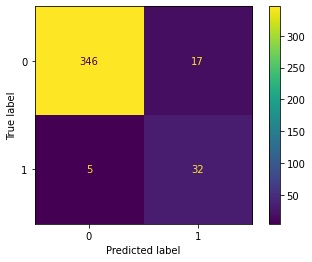

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = dict_hist[bas_phase]['y_true'][0]
y_pred = [1 if y_pred_ >= anomaly_threshold else 0 for y_pred_ in dict_hist[bas_phase]['y_hat_scores'][0]]
classes_ = [0, 1]
cm = confusion_matrix(y_true, y_pred, labels=classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_)
disp.plot()
plt.show()

In [55]:
np.where(np.array(dict_hist['tst']['y_true'][0])==1) 

(array([  7,   8,  19,  22,  30,  55,  60,  73,  91, 104, 114, 131, 158,
        159, 165, 181, 186, 193, 199, 202, 207, 210, 219, 224, 241, 268,
        270, 300, 305, 306, 326, 327, 329, 330, 348, 355, 397]),)

In [56]:
pd.DataFrame({'lbl': np.array(dict_hist['tst']['y_true'][0])})['lbl'].value_counts()  # 37/400 anomalies  363/400 normals

lbl
0.0    363
1.0     37
Name: count, dtype: int64

<AxesSubplot: xlabel='x'>

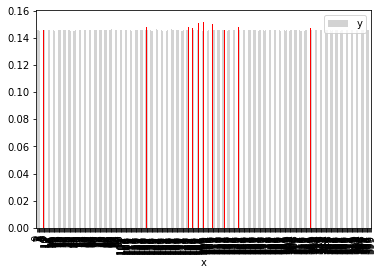

In [57]:
pd.DataFrame({'x': range(0,400), 'y': np.array(dict_hist['tst']['y_hat_scores'][0])}).plot.bar(x=0, y=1, color=['r' if ylbl == 1. else 'lightgray' for ylbl in np.array(dict_hist['tst']['y_true'][0])])

Text(0.5, 1.0, 'roc:0.986|prc:0.908|fpr:0.047|fnr:0.135')

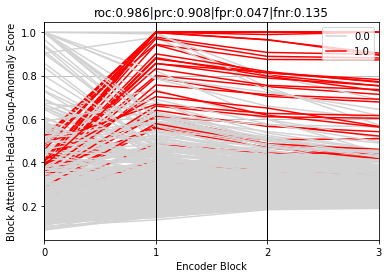

In [58]:
ax=pd.plotting.parallel_coordinates(
    df_bas, 'Label', color=('lightgray', 'r'), sort_labels=True
)
ax.set_xlabel("Encoder Block")
ax.set_ylabel("Block Attention-Head-Group-Anomaly Score") # <- BAS != y_hat_score !!! 
plt.title(f"roc:{round(dict_hist[bas_phase]['auroc'][0], 3)}|prc:{round(dict_hist[bas_phase]['auprc'][0], 3)}|fpr:{round(fp/(fp+tn),3)}|fnr:{round(fn/(fn+tp),3)}")

In [141]:
dict_hist[bas_phase].keys()

dict_keys(['y_hat_scores', 'y_true', 'losses', 'auroc', 'auprc'])

In [49]:
#xb, yb = next(iter(dl_vld))
#pd.DataFrame(xb[2]).plot.scatter(x=0,y=1)

In [50]:
#best_epoch=11 #early_stopping.val_loss_min_epoch
#bidx=0
#pd.DataFrame(model.energies['trn']['enc0'][best_epoch][bidx].flatten()).value_counts()

In [51]:
#bidx=0
#model.energies['trn']['enc0'].energies['o_mha0']  # dict_keys(['o_mha0', 'i_ffn0', 'o_ffn0', 'o_nrm0'])
#print(pd.DataFrame(model.encoder[0].energies['vld']['o_mha0'][best_epoch][bidx].flatten()).value_counts())
#print(pd.DataFrame(model.encoder[0].energies['vld']['i_ffn0'][best_epoch][bidx].flatten()).value_counts())

In [52]:
#pd.DataFrame(model.energies['vld']['x1'][0][1].flatten()).value_counts() #[0].squeeze(2).flatten()).value_counts()
#pd.DataFrame(model.energies['vld']['enc1'][0][1].flatten()).value_counts() #[0].squeeze(2).flatten()).value_counts()

In [53]:
#pd.DataFrame(model.energies[-1].squeeze(2).flatten()).value_counts() #.plot(kind='hist')#.shape #.shape#.squeeze(0)#

<AxesSubplot: title={'center': 'validation metrics (9 - seed: 1)'}>

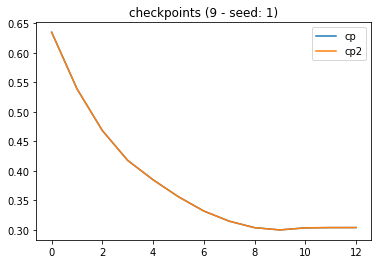

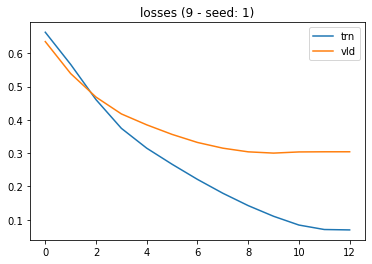

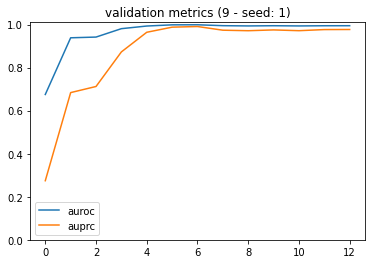

In [55]:
yticks=None
best_ep = 9 #early_stopping.val_loss_min_epoch
pd.DataFrame({'cp': dict_hist['cp'],'cp2': dict_hist['cp2']}).plot(title=f"checkpoints ({best_ep} - seed: {seed})", yticks=yticks)
pd.DataFrame({'trn': dict_hist['trn']['losses'], 'vld': dict_hist['vld']['losses']}).plot(title=f"losses ({best_ep} - seed: {seed})", yticks=yticks)
pd.DataFrame({'auroc': dict_hist['vld']['auroc'], 'auprc': dict_hist['vld']['auprc']}).plot(title=f"validation metrics ({best_ep} - seed: {seed})", yticks=yticks, ylim=[0,1.01])

In [56]:
#best_ep = 11 #early_stopping.val_loss_min_epoch
len(dict_hist['trn']['y_hat_scores'][best_ep])

2000

<AxesSubplot: ylabel='Frequency'>

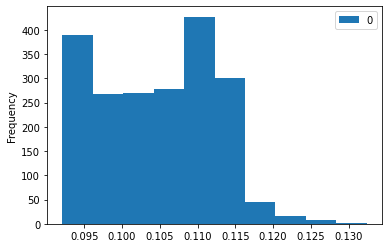

In [57]:
pd.DataFrame(dict_hist['trn']['y_hat_scores'][best_ep]).plot(kind='hist')

<AxesSubplot: ylabel='Frequency'>

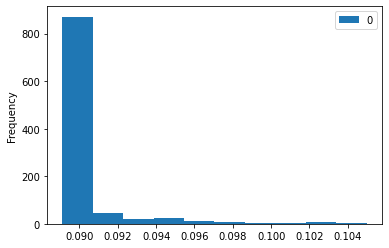

In [58]:
pd.DataFrame(dict_hist['vld']['y_hat_scores'][best_ep]).plot(kind='hist')

In [59]:
auroc = dict_hist['vld']['auroc'][best_ep]
auprc = dict_hist['vld']['auprc'][best_ep]
print(f"AUROC({best_ep}) {auroc} AUPRC({best_ep}) {auprc}")

AUROC(9) 0.9943976249760582 AUPRC(9) 0.9748961522274749


In [60]:
midxr = np.argmax(dict_hist['vld']['auroc'])
midxp = np.argmax(dict_hist['vld']['auprc'])
max_auroc = dict_hist['vld']['auroc'][midxr]
max_auprc = dict_hist['vld']['auprc'][midxp]
print(f"max_auroc({midxr}) {max_auroc} max_auprc({midxp}) {max_auprc}")

max_auroc(6) 0.9987550277724574 max_auprc(6) 0.9906754829406061


In [61]:
auroc = dict_hist['tst']['auroc'][-1]
auprc = dict_hist['tst']['auprc'][-1]
print(f"AUROC(TST) {auroc} AUPRC(TST) {auprc}")

AUROC(TST) 0.9858536222172586 AUPRC(TST) 0.9160561646000169


In [104]:
#bidx=2
#best_epoch=early_stopping.val_loss_min_epoch
#pd.DataFrame(model.energies['vld']['enc0'][best_epoch][bidx].flatten()).value_counts()

In [105]:
#model.energies['vld']['enc0'][best_epoch]

In [106]:
#pd.DataFrame(dict_hist['vld']['losses']) #[early_stopping.val_loss_min_epoch]).plot(kind='hist')

anomalies: (tensor([   7,   55,   57,   60,   73,   76,   80,   83,   94,   99,  105,  115,
         117,  123,  130,  131,  165,  178,  179,  184,  201,  207,  210,  211,
         219,  224,  226,  231,  241,  242,  245,  247,  250,  294,  297,  300,
         311,  317,  347,  354,  384,  405,  443,  500,  506,  509,  510,  513,
         542,  543,  544,  546,  567,  573,  575,  580,  590,  603,  626,  665,
         698,  714,  717,  719,  732,  742,  748,  783,  809,  826,  839,  842,
         860,  867,  885,  901,  906,  909,  912,  915,  925,  931,  933,  939,
         946,  979,  981,  986,  999, 1016, 1018, 1031, 1032, 1046, 1049, 1096,
        1115, 1131, 1132, 1143, 1158, 1177, 1195, 1231, 1235, 1238, 1292, 1294,
        1300, 1330, 1346, 1350, 1353, 1362, 1367, 1375, 1381, 1386, 1402, 1408,
        1411, 1415, 1424, 1436, 1441, 1449, 1454, 1460, 1461, 1464, 1475, 1501,
        1509, 1527, 1529, 1535, 1555, 1567, 1572, 1581, 1593, 1620, 1631, 1634,
        1637, 1640, 1646, 16

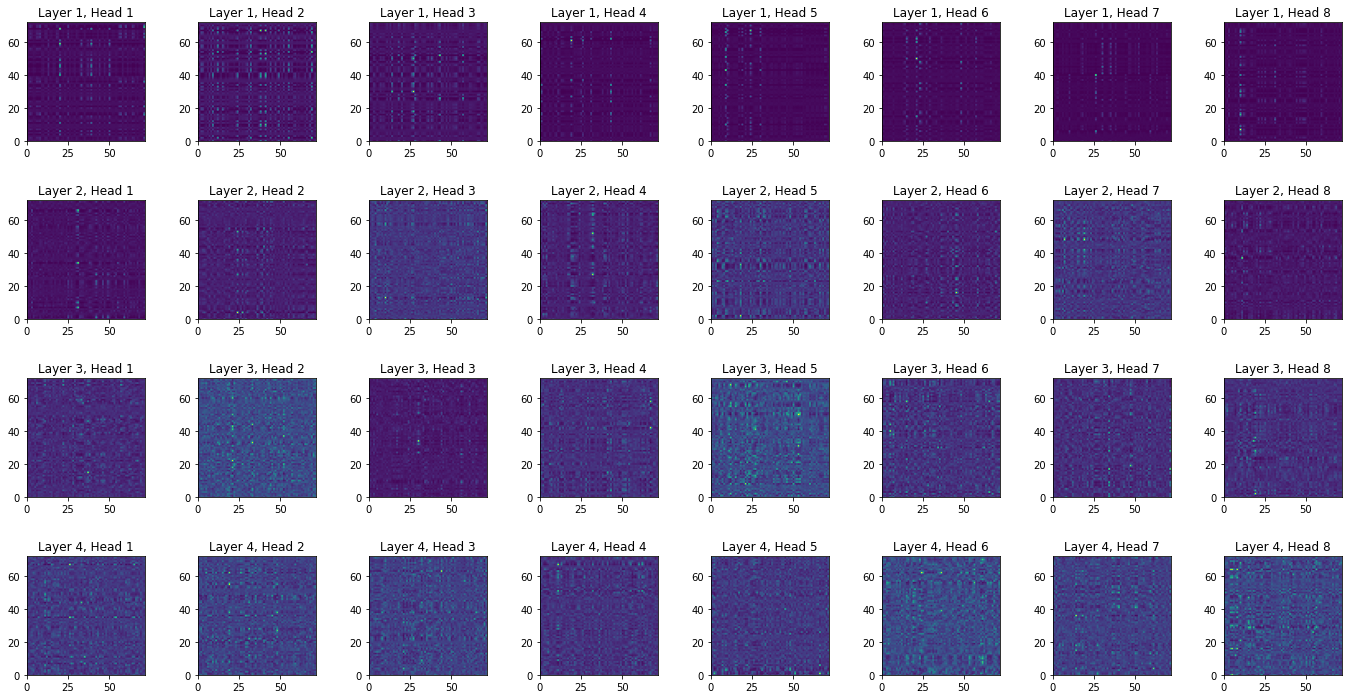

In [62]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    
    if type(attn_maps) == list:
        attn_maps_ = [m[idx].detach().cpu().numpy() for m in attn_maps]
    else:
        attn_maps_ = [m.detach().cpu().numpy() for m in attn_maps]

    # torch.Size([1, 8, 72, 72])
    num_heads = attn_maps_[0].shape[0]
    num_layers = len(attn_maps_)
    seq_len = attn_maps_[0].shape[-1]
    
    print(f"num_heads {num_heads} num_layers {num_layers} seq_len {seq_len}")
    
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads * fig_size, num_layers * fig_size))
    
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]

    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps_[row][column], origin="lower", vmin=0)
            ax[row][column].set_xlim([0,seq_len])
            ax[row][column].set_ylim([0,seq_len])
            ax[row][column].set_title("Layer %i, Head %i" % (row + 1, column + 1))

    fig.subplots_adjust(hspace=0.5)
    plt.show()

def show_attn_maps(model, sample_idx):
    attn_maps=[]
    for enc_layer in model.encoder:
        attn_maps.append(np.array(enc_layer.attn)[:,sample_idx,:,:])
    attn_maps_ = torch.tensor(np.array(attn_maps).reshape(model.num_layers, model.num_heads, model.d_k, model.d_k))
    plot_attention_maps(None, attn_maps_)

print(f"anomalies: {torch.where(y==1)}")
sid=7
show_attn_maps(best_model, sid)

<AxesSubplot: >

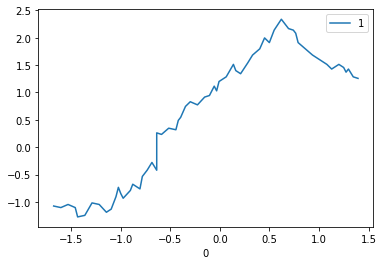

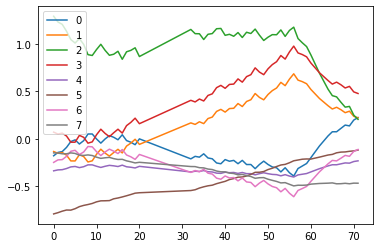

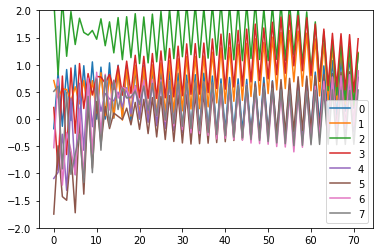

In [65]:
from loaddataset import TrajectoryDataset
from torch.utils.data import DataLoader
import os
dl_vld = DataLoader(ds_vld, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=os.cpu_count()-1, worker_init_fn=seed_worker)
x, y = next(iter(dl_vld))

best_model.to('cpu')

#sid=7
pd.DataFrame(x[sid]).plot(x=0, y=1)
xi = best_model.input_embedding(x.float())
pd.DataFrame(xi[sid].detach().cpu().numpy()).plot()
pd.DataFrame((xi.cpu() + best_model.positional_encoding(xi.cpu()))[sid].detach().cpu().numpy(), list(range(0,xi.shape[1]))).plot(ylim=[-2,2])

In [66]:
best_model.encoder[0].energies['vld'].keys()

dict_keys([])

In [69]:
best_model.to('cpu')
best_model.eval()

x0 = best_model.input_embedding(x.float()).to('cpu')
x1 = x0 + best_model.positional_encoding(x0).to('cpu') # + torch.Size([32, 1]) 

bidx=0
ep=0
#best_model.encoder[0].forward(x1, ep, bidx)

#pd.DataFrame() #[early_stopping.val_loss_min_epoch] # dict_keys(['o_mha0', 'i_ffn0', 'o_ffn0', 'o_nrm0'])
#pd.DataFrame(best_model.encoder[0].energies['vld']['o_mha0'][ep][bidx].flatten()).plot(kind='hist')

In [ ]:
bidx=1
pd.DataFrame(model.encoder[0].energies['vld']['i_ffn0'][ep][bidx].flatten()).plot(kind='hist')

In [ ]:
from loaddataset import TrajectoryDataset
from torch.utils.data import DataLoader
import argparse

traj_step_features=['X_Coord','Y_Coord']
root_dir = './datasets/files_valid/'
ds_trn_id, ds_vld_id, ds_tst_id = 25, 22, 24
dataset_name='trajectory'
seq_len=(72,500)['bright' in dataset_name]
sc='robust'

#bs=(256,25)['bright' in exp['setting']['ds']['dataset_name']]
bs=(256,25)['bright' in dataset_name]


args = argparse.Namespace(d_step_feat=len(traj_step_features), d_inp_size=72, d_inp_embed_size=1, d_k=72, d_ffn_embed_size=2048, num_heads=8, enc_layers=4, k=None, sc=sc, 
                          lr=1e-03, batch_size=bs, epochs=1, clip_value=5., pat_es=20, pat_sched=15, wd=0., min_lr=1e-6, drop=0.) #todo: dff_embed_size=2048, drop=0.01, 0.05, 0.1

model = GADFormer(d_step_feat=args.d_step_feat, d_inp_size=args.d_inp_size, d_inp_embed_size=args.d_inp_embed_size, d_k=args.d_k, d_ffn_embed_size=args.d_ffn_embed_size, 
                  num_heads=args.num_heads, num_layers=args.enc_layers, dropr=args.drop, save_attn=True)

ds_trn = TrajectoryDataset(root_dir, file_id=ds_trn_id, mode='train', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None) #25
ds_vld = TrajectoryDataset(root_dir, file_id=ds_vld_id, mode='valid', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None) #22
ds_tst = TrajectoryDataset(root_dir, file_id=ds_tst_id, mode='test', sc=args.sc, submode='', traj_step_features=traj_step_features, k=None) #24

from loaddataset import TrajectoryDataset
from torch.utils.data import DataLoader
import os
dl_vld = DataLoader(ds_vld, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=os.cpu_count()-1, worker_init_fn=seed_worker)
x, y = next(iter(dl_vld))


torch.where(y==1)
#torch.where(y==1) # anomalies
# (tensor([  7,  55,  57,  60,  73,  76,  80,  83,  94,  99, 105, 115, 117, 123,
#         130, 131, 165, 178, 179, 184, 201, 207, 210, 211, 219, 224, 226, 231,
#         241, 242, 245, 247, 250]),)

sid=8
pd.DataFrame(x[sid]).plot(x=0, y=1)

xi = model.input_embedding(x.float())
xi.shape

pd.DataFrame(xi[sid].detach().cpu().numpy()).plot()

pd.DataFrame((xi.cpu() + model.positional_encoding(xi.cpu()))[sid].detach().cpu().numpy(), list(range(0,xi.shape[1]))).plot(ylim=[-2,2])

#dev=torch.device('cuda')
#model.to(dev)
#model.forward(x1.to(dev))
#print(next(model.parameters()).device)
#print(model.positional_encoding.pe.device)
#for enc in model.encoder:
#    print("---")
#    for mha in enc.mh_att.mha:
#        print(mha.fc_qkv.weight.type())

In [ ]:
import os
from utils import seed_worker
num_worker = os.cpu_count()-1
device=torch.device('cuda')

#loss_fn = nn.BCELoss() #F.binary_cross_entropy()

dl_trn = DataLoader(ds_trn, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=num_worker, worker_init_fn=seed_worker) 

xa, _ = next(iter(dl_trn))

model.train()
model=model.to(device)
xa = xa.float().to(device)

y_hat_score = model.forward(xa, 0) # predicted probability for an abnormal group (0. = normal group)
print(y_hat_score.shape)

y_aux_labels = torch.zeros((xa.shape[0], 1)) # auxilary target label based on assumption of the majority of normal groups
y_aux_labels = y_aux_labels.float().to(device)

#loss = loss_fn(y_hat_score, y_aux_labels)
loss = F.binary_cross_entropy(y_hat_score, y_aux_labels)

loss.item()